# Use Case Name : UC00204_Resilient_Education_Access

# Authored by: Ekanayake Mudiyanselage Ruvinya Yasasmee Ekanayake

Duration - 90 mins

Level - Intermediate

Pre-requisite Skills - Python, Pandas, Data visualisation, Data handling, Data cleaning

# Objective

Determine capacity shortfalls at the suburb level, quantify and forecast demand for school-age (5–19) students throughout the City of Melbourne, and evaluate geographic resilience by looking at the variety, proximity, and redundancy of school offerings. In order to guide the planning of resilient and equitable education infrastructure, assess equity in access, model continuity shocks and growth scenarios, and develop a clear, time-phased seats/schools build plan by goal year.

# What this usecase will teach you

1. How to analyse capacity gaps, access disparity, and school demand at the suburb level.
2. How to test local school coverage using catchment-radius and proximity approaches.
3. How to create a risk index that incorporates access distance and demand shortage.
4. How to stress test alternate capacity designs and monitor cumulative unmet demand.
5. How to use future scenarios to inform policy under various growth assumptions.


# Datasets

1. School Locations Dataset (2024): Includes geographic details of schools in Melbourne.
Department of Education (Vic). (2024). School Locations—All Victorian schools (CSV). Victoria State Government – DataVic. https://www.education.vic.gov.au/Documents/about/research/datavic/dv378_DataVic-SchoolLocations-2024.csv




2. Population Forecasts Dataset (2020–2040): Provides suburb-level forecasts, including age groups and year-wise projections.
City of Melbourne. (2020–2040). Population forecasts by small area (API v2.1 CSV export). City of Melbourne Open Data. https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/city-of-melbourne-population-forecasts-by-small-area-2020-2040/exports/csv?delimiter=%2C

## Imports

This imports cell loads the notebook's core tools: pandas and numpy for data manipulation and numerical work, matplotlib for quick visualisations, requests for fetching data from the web (API/CSV URLs), math for small numeric helpers and folium for optional map views using latitude/longitude. Collecting these up front ensures consistency in the environment and prevents dispersed, repeating imports later.

In [41]:
import pandas as pd
import numpy as np
import math
import requests
import matplotlib.pyplot as plt
import folium
import re

Specifies the two hosted data sources: School Locations 2024 (supply) and City of Melbourne Population Forecasts 2020-2040 via API v2.1 (demand). Using URLs makes the notebook repeatable.

In [42]:

# School locations dataset
SCHOOLS_URL = "https://www.education.vic.gov.au/Documents/about/research/datavic/dv378_DataVic-SchoolLocations-2024.csv"

# Population forecast dataset
POP_URL = "https://data.melbourne.vic.gov.au/api/v2/catalog/datasets/city-of-melbourne-population-forecasts-by-small-area-2020-2040/exports/csv?delimiter=%2C"


## Loading datasets

Reads School Locations (CSV) and City of Melbourne Population Forecasts (API v2.1 CSV) into DataFrames. To handle special characters in the schools file, use ISO-8859-1, and set low_memory=False for reliable types. Prints raw shapes and displays the first six rows to ensure schema and connectivity.

In [43]:
# Read source data directly from the two URLs
school_df = pd.read_csv(SCHOOLS_URL, encoding="ISO-8859-1", low_memory=False)
pop_df = pd.read_csv(POP_URL, low_memory=False)

# Show row/column counts for both raw tables
print("Raw shapes:", school_df.shape, pop_df.shape)

# Quick peek at the first rows
display(school_df.head(6))
display(pop_df.head(6))


Raw shapes: (2294, 22) (10584, 5)


,Education_Sector,Entity_Type,School_No,School_Name,School_Type,Address_Line_1,Address_Line_2,Address_Town,Address_State,Address_Postcode,...,Postal_Town,Postal_State,Postal_Postcode,Full_Phone_No,Region_Name,AREA_Name,LGA_ID,LGA_Name,X,Y
0,Catholic,2,20,Parade College,Secondary,1436 Plenty Road,NaN,BUNDOORA,VIC,3083,...,BUNDOORA,VIC,3083.0,03 9468 3300,NORTH-WESTERN VICTORIA,North Eastern Melbourne,66,Banyule (C),145.06698,-37.69018
1,Catholic,2,25,Simonds Catholic College,Secondary,273 Victoria Street,NaN,WEST MELBOURNE,VIC,3003,...,WEST MELBOURNE,VIC,3003.0,03 9321 9200,SOUTH-WESTERN VICTORIA,Western Melbourne,460,Melbourne (C),144.95288,-37.80597
2,Catholic,2,26,St Marys College Melbourne,Secondary,11 Westbury Street,NaN,ST KILDA EAST,VIC,3183,...,ST KILDA,VIC,3182.0,03 9529 6611,SOUTH-EASTERN VICTORIA,Bayside Peninsula,590,Port Phillip (C),144.99700,-37.85936
3,Catholic,2,28,St Patrick's College Ballarat,Secondary,1431 Sturt Street,NaN,BALLARAT,VIC,3350,...,BALLARAT,VIC,3350.0,03 5331 1688,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.83156,-37.55971
4,Catholic,2,29,St Patrick's School,Primary,119 Drummond Street South,NaN,BALLARAT,VIC,3350,...,BALLARAT WEST,VIC,3350.0,03 5332 7680,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.84715,-37.56440
5,Catholic,2,30,St Alipius' Parish School,Primary,106-108 Victoria Street,NaN,BALLARAT EAST,VIC,3350,...,BALLARAT EAST,VIC,3350.0,03 5331 1816,SOUTH-WESTERN VICTORIA,Central Highlands,57,Ballarat (C),143.87401,-37.56170


,geography,year,gender,age,value
0,Kensington,2037,Male,Age 45-49,747
1,Kensington,2038,Female,Age 20-24,428
2,Kensington,2038,Female,Age 75-79,144
3,Kensington,2038,Male,Age 50-54,267
4,Kensington,2038,Male,Age 75-79,172
5,Kensington,2039,Female,Age 10-14,366


## Standardise column names for merging

Columns are renamed to a common schema for easier joins, including suburb (from Address_Town), lon and lat (from X and Y), and standard fields school_name, sector, school_type, lga, area, year, age_group, and population. Prints the revised column lists for verification.


In [44]:
# Schools: standardise / add suburb
school_df = school_df.rename(columns={
    "School_Name":"school_name",
    "Education_Sector":"sector",
    "School_Type":"school_type",
    "LGA_Name":"lga",
    "Address_Town":"suburb",   # will align with pop_df['area']
    "X":"lon",                 # longitude
    "Y":"lat"                  # latitude
})

# Population: standardise
pop_df = pop_df.rename(columns={
    "geography":"area",
    "year":"year",
    "age":"age_group",
    "value":"population"
})

# Check the new schemas
print("School cols:", school_df.columns.tolist())
print("Pop cols:", pop_df.columns.tolist())


School cols: ['sector', 'Entity_Type', 'School_No', 'school_name', 'school_type', 'Address_Line_1', 'Address_Line_2', 'suburb', 'Address_State', 'Address_Postcode', 'Postal_Address_Line_1', 'Postal_Address_Line_2', 'Postal_Town', 'Postal_State', 'Postal_Postcode', 'Full_Phone_No', 'Region_Name', 'AREA_Name', 'LGA_ID', 'lga', 'lon', 'lat']
Pop cols: ['area', 'year', 'gender', 'age_group', 'population']


## Data Cleaning

Schools

Selects relevant columns, converts lat/lon to numeric, removes invalid rows, normalises text (strip + title-case), de-duplicates by name/LGA/suburb/coordinates, and outputs the cleaned shape and a preview.

In [45]:
# Keep only needed columns
school_df = school_df[["school_name","sector","school_type","lga","suburb","lat","lon"]].copy()

# Make coordinates numeric and drop rows without valid coordinates
school_df["lat"] = pd.to_numeric(school_df["lat"], errors="coerce")
school_df["lon"] = pd.to_numeric(school_df["lon"], errors="coerce")
school_df = school_df.dropna(subset=["lat","lon"])

# Normalise text
for c in ["school_name","sector","school_type","lga","suburb"]:
    school_df[c] = school_df[c].astype(str).str.strip().str.title()

# Remove duplicates (same school/location)
school_df = school_df.drop_duplicates(subset=["school_name","lga","suburb","lat","lon"])

print("Schools (clean):", school_df.shape)
display(school_df.head(3))


Schools (clean): (2293, 7)


,school_name,sector,school_type,lga,suburb,lat,lon
0,Parade College,Catholic,Secondary,Banyule (C),Bundoora,-37.69018,145.06698
1,Simonds Catholic College,Catholic,Secondary,Melbourne (C),West Melbourne,-37.80597,144.95288
2,St MaryS College Melbourne,Catholic,Secondary,Port Phillip (C),St Kilda East,-37.85936,144.99700


# Population

By keeping only the most important variables (region, year, age group, and population), forcing year and population to be numeric types, and standardising text fields (by removing whitespace and using title case), this phase gets the population dataset ready for analysis. The dataset is limited to predicted years starting in 2025, and records with faulty or missing values are eliminated. Subsequent metrics of equitable and resilient education access are supported by the well-formed table that results from robust modeling of future student demand across suburbs.


In [46]:
# Keep only needed columns
pop_df = pop_df[["area","year","age_group","population"]].copy()

# Ensure numeric types
pop_df["year"] = pd.to_numeric(pop_df["year"], errors="coerce")
pop_df["population"] = pd.to_numeric(pop_df["population"], errors="coerce")

# Clean text fields
for c in ["area","age_group"]:
    pop_df[c] = pop_df[c].astype(str).str.strip().str.title()

# Drop invalids and keep forecast years
pop_df = pop_df.dropna(subset=["year","population"])
pop_df = pop_df[pop_df["year"] >= 2025]

print("Population (clean):", pop_df.shape)
display(pop_df.head(3))


Population (clean): (9576, 4)


,area,year,age_group,population
0,Kensington,2037,Age 45-49,747
1,Kensington,2038,Age 20-24,428
2,Kensington,2038,Age 75-79,144


With 9,576 rows and four important columns, suburb (area), forecast year, age group, and projected population, the output displays a cleaned population dataset. While year and population are expressed in numerical form, suburb names and age categories have been standardised. Each record now clearly indicates a suburb-year-age-group population that can be used for demand modeling, as only anticipated years from 2025 onward are included.

## Aggregate school-age (5-19) population by year, location, and citywide total

In this step, only the school-age cohort (5–19 years old) is included in the cleansed population data. To generate school_age, it first aggregates the population counts by suburb and year after applying a filter to identify the pertinent age groups. The total number of school-age people in the city each year is obtained by further aggregation. Both general and suburb-level projections of prospective student demand are provided by these outputs.

In [47]:
# Filter ages 5–19
school_age_mask = pop_df["age_group"].str.contains(r"5-9|10-14|15-19")

# Filter ages 5–19
school_age = (
    pop_df[school_age_mask]
    .groupby(["year","area"], as_index=False)["population"]
    .sum()
    .rename(columns={"population":"school_age_pop"})
)
# Citywide total 5–19 by year
city_school_age = school_age.groupby("year", as_index=False)["school_age_pop"].sum()

print("School-age per area/year:")
display(school_age.head(10))
print("Citywide school-age total by year:")
display(city_school_age.head(10))


School-age per area/year:


,year,area,school_age_pop
0,2025,Carlton,2656
1,2025,City Of Melbourne,15995
2,2025,Docklands,1123
3,2025,East Melbourne,152
4,2025,Kensington,1413
5,2025,Melbourne (Cbd),4487
6,2025,Melbourne (Remainder),152
7,2025,North Melbourne,1928
8,2025,Parkville,1662
9,2025,Port Melbourne,2


Citywide school-age total by year:


,year,school_age_pop
0,2025,31991
1,2026,32614
2,2027,33616
3,2028,34942
4,2029,36259
5,2030,37778
6,2031,39517
7,2032,41066
8,2033,42852
9,2034,44665


The first table shows the estimated number of people in each suburb who are between the ages of 5 and 19 in 2025, showing differences across regions like Carlton, the City of Melbourne, and North Melbourne. This gives an overview of anticipated student demand at the suburban level.

The citywide total school-age population by year is displayed in the second table. It starts at about 32,000 in 2025 and gradually increases to almost 44,000 by 2034. This demonstrates the general upward tendency in the city's need for education.

## Estimate capacity according to school type

Using basic guidelines (~500 for primary, ~1,000 for secondary, ~800 for combined P–12, ~200 for special schools, and a 600-place fallback for anything unmapped), this stage determines a pragmatic capacity figure for each school based on its nature. After that, it allocates these estimates to each record, determines the total capacity for the entire city, and generates a summary table by sector and school_type. When official capacity data is lacking or insufficient, this establishes a baseline for accessibility measurements that can be defended.

In [48]:
def estimate_capacity(t):
    t = str(t).lower()
    if "primary"   in t: return 500
    if "secondary" in t: return 1000
    if "p-12" in t or "pri/sec" in t: return 800
    if "special"   in t: return 200
    return 600  # fallback

school_df["capacity"] = school_df["school_type"].apply(estimate_capacity)
total_capacity = int(school_df["capacity"].sum())

print("Estimated total city capacity:", total_capacity)
display(school_df.groupby(["school_type","sector"], as_index=False)["capacity"].sum())


Estimated total city capacity: 1365400


,school_type,sector,capacity
0,Language,Government,2400
1,Pri/Sec,Catholic,10400
2,Pri/Sec,Government,64000
3,Pri/Sec,Independent,124800
4,Primary,Catholic,196000
5,Primary,Government,572000
6,Primary,Independent,17000
7,Secondary,Catholic,84000
8,Secondary,Government,257000
9,Secondary,Independent,15000


The output breaks out the estimated capacity of schools by sector and kind. The majority of the 1.36 million spots available in the city are provided by government institutions, especially primary and secondary ones. While special schools, while on a smaller scale, are included for completeness, Catholic and independent schools also contribute significantly to capacity. The predicted supply baseline that can be contrasted with the anticipated demand from students is summarised.

## Citywide demand vs capacity

In this section, the predicted overall school capacity in the City of Melbourne is contrasted with the projected student demand (ages 5-19). It determines the first year in which demand surpasses capacity, computes the annual difference between supply and demand, and displays the findings. Demand and capacity are plotted over time, with years with a shortfall indicated by darkened areas.

First year demand exceeds capacity: 2025


,year,school_age_pop,capacity,gap
0,2025,31991,15900,16091
1,2026,32614,15900,16714
2,2027,33616,15900,17716
3,2028,34942,15900,19042
4,2029,36259,15900,20359
5,2030,37778,15900,21878
6,2031,39517,15900,23617
7,2032,41066,15900,25166
8,2033,42852,15900,26952
9,2034,44665,15900,28765


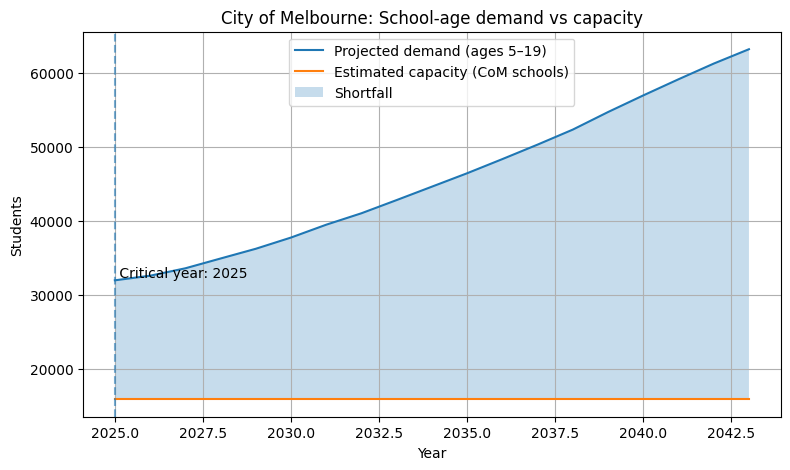

In [49]:
# City of Melbourne demand vs capacity

# Use CoM-only schools for capacity (build if not already made)
try:
    total_capacity = int(schools_com["capacity"].sum())
except NameError:
    # build CoM subset and capacity if not already done
    schools_com = school_df[school_df["lga"].str.strip().eq("Melbourne (C)")].copy()
    def estimate_capacity(t):
        t = str(t).lower()
        if "primary"   in t: return 500
        if "secondary" in t: return 1000
        if "p-12" in t or "pri/sec" in t: return 800
        if "special"   in t: return 200
        return 600
    schools_com["capacity"] = schools_com["school_type"].apply(estimate_capacity)
    total_capacity = int(schools_com["capacity"].sum())

# build table
demand_vs_capacity = city_school_age.copy()       # CoM school-age totals by year
demand_vs_capacity["capacity"] = total_capacity
demand_vs_capacity["gap"] = demand_vs_capacity["school_age_pop"] - demand_vs_capacity["capacity"]

# First year where demand > capacity
critical_year = (
    demand_vs_capacity.loc[demand_vs_capacity["gap"] > 0, "year"].min()
    if (demand_vs_capacity["gap"] > 0).any() else None
)
print("First year demand exceeds capacity:", critical_year)
display(demand_vs_capacity.head(12))

# plot
plt.figure(figsize=(9,5))
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["school_age_pop"],
         label="Projected demand (ages 5–19)")
plt.plot(demand_vs_capacity["year"], demand_vs_capacity["capacity"],
         label="Estimated capacity (CoM schools)")
plt.fill_between(
    demand_vs_capacity["year"],
    demand_vs_capacity["capacity"],
    demand_vs_capacity["school_age_pop"],
    where=demand_vs_capacity["gap"] > 0,
    alpha=0.25, label="Shortfall"
)
# Mark the critical year on the chart
if critical_year is not None:
    y = demand_vs_capacity.loc[demand_vs_capacity["year"]==critical_year, "school_age_pop"].values[0]
    plt.axvline(critical_year, linestyle="--", alpha=0.6)
    plt.text(critical_year, y, f" Critical year: {critical_year}", va="bottom")

plt.xlabel("Year"); plt.ylabel("Students")
plt.title("City of Melbourne: School-age demand vs capacity")
plt.legend(); plt.grid(True); plt.show()


According to the data, the City of Melbourne's anticipated student demand already surpasses the predicted capacity of schools starting in 2025, and the difference is growing yearly. The shortage increases to over 32,000 locations by 2036.

The graph illustrates this pattern: a sizable and growing shaded shortfall area results from a significant increase in demand and a flat capacity. There is a mark for the crucial year of 2025, which is when there are not enough schools to meet demand.

# Converting the deficit into the need for schools

In this stage, the estimated number of extra schools needed is converted from the expected student shortage. To prevent negative shortages, the gap column is clipped at zero and then divided by the approximate number of the schools (~500 for primary, ~1000 for secondary). In addition to providing a realistic planning perspective beyond abstract seat counts, the result gives an approximate estimate of the number of new schools that would be required annually to meet demand.

In [50]:
# This converts population shortfall into rough 'schools needed'.
dvc = demand_vs_capacity.copy()

# Shortfall = gap but not below zero (no negative shortages)
dvc["shortfall"] = np.maximum(dvc["gap"], 0)

# Convert shortfall into rough school counts
dvc["primary_schools_needed_~500"]   = np.ceil(dvc["shortfall"] / 500).astype(int)
dvc["secondary_schools_needed_~1000"] = np.ceil(dvc["shortfall"] / 1000).astype(int)

# Show the planning table
display(dvc[["year","school_age_pop","capacity","gap",
             "primary_schools_needed_~500","secondary_schools_needed_~1000"]].head(15))


,year,school_age_pop,capacity,gap,primary_schools_needed_~500,secondary_schools_needed_~1000
0,2025,31991,15900,16091,33,17
1,2026,32614,15900,16714,34,17
2,2027,33616,15900,17716,36,18
3,2028,34942,15900,19042,39,20
4,2029,36259,15900,20359,41,21
5,2030,37778,15900,21878,44,22
6,2031,39517,15900,23617,48,24
7,2032,41066,15900,25166,51,26
8,2033,42852,15900,26952,54,27
9,2034,44665,15900,28765,58,29


## Suburban demand-supply gap

In this stage, a demand-supply frame for the target year (2043 in this case) is constructed at the suburb level. In addition to combining the two datasets and guaranteeing one clean row per suburb, the code normalises suburb names and combines expected student demand and available school capacity. The demand-supply gap is then calculated as a contextual pressure indicator. For comparisons at the suburb level in subsequent study, this table is the only trustworthy source.


In [51]:
# Suburb demand–supply frame (robust, single source of truth)

# Normalise function
if '_norm_suburb' not in globals():
    def _norm_suburb(s: str) -> str:
        s = str(s).strip()
        s = re.sub(r"\s+", " ", s)
        return s.title()

# Choose target year (latest available)
if 'TARGET_YEAR' not in globals() or TARGET_YEAR is None:
    assert 'school_age' in globals(), "Expected a 'school_age' table with 'year', 'area', 'school_age_pop'"
    assert {'year','area','school_age_pop'}.issubset(school_age.columns), "school_age is missing required columns"
    TARGET_YEAR = int(pd.to_numeric(school_age['year'], errors='coerce').max())

# Demand
tmp = school_age.loc[pd.to_numeric(school_age["year"], errors="coerce") == TARGET_YEAR,
                     ["area","school_age_pop"]].copy()
tmp["suburb"] = tmp["area"].map(_norm_suburb)

suburb_demand = (
    tmp.groupby("suburb", as_index=False)["school_age_pop"]
       .sum()
       .rename(columns={"school_age_pop": "demand_students"})
)

# Supply
assert 'schools_com' in globals(), "Expected a 'schools_com' table (City of Melbourne schools) with 'suburb' and 'capacity'"
assert {'suburb','capacity'}.issubset(schools_com.columns), "schools_com is missing required columns"

schools_com = schools_com.copy()
schools_com["suburb"] = schools_com["suburb"].map(_norm_suburb)

suburb_supply = (
    schools_com.groupby("suburb", as_index=False)["capacity"]
               .sum()
               .rename(columns={"capacity": "supply_capacity"})
)

# Merge (outer to keep suburbs that only appear in one side), ensure numeric, and guarantee uniqueness
suburb_gap = (suburb_demand.merge(suburb_supply, on="suburb", how="outer")
                          .fillna(0))

# Ensure numerics are clean
suburb_gap["demand_students"] = pd.to_numeric(suburb_gap["demand_students"], errors="coerce").fillna(0.0)
suburb_gap["supply_capacity"] = pd.to_numeric(suburb_gap["supply_capacity"], errors="coerce").fillna(0.0)

# If any strays slipped through, collapse to one row per suburb
suburb_gap = suburb_gap.groupby("suburb", as_index=False).sum(numeric_only=True)

# Gap
suburb_gap["gap_students"] = suburb_gap["demand_students"] - suburb_gap["supply_capacity"]

print(f"Built suburb demand–supply frame for {TARGET_YEAR}. Rows: {len(suburb_gap)}")
display(suburb_gap.sort_values("demand_students", ascending=False).head(15))


Built suburb demand–supply frame for 2043. Rows: 14


,suburb,demand_students,supply_capacity,gap_students
1,City Of Melbourne,31632.0,0.0,31632.0
5,Melbourne,7929.0,3800.0,4129.0
6,North Melbourne,5412.0,2400.0,3012.0
0,Carlton,4099.0,1000.0,3099.0
12,Southbank,3098.0,1000.0,2098.0
4,Kensington,3017.0,2000.0,1017.0
2,Docklands,2650.0,500.0,2150.0
7,Parkville,2643.0,1200.0,1443.0
13,West Melbourne,1466.0,1000.0,466.0
11,South Yarra,579.0,1800.0,-1221.0


According to the resulting table, there will be significant shortages of student spots in a number of suburbs by 2043, including the City of Melbourne, Melbourne, North Melbourne, and Carlton. Some regions, like South Melbourne and South Yarra, exhibit negative gaps, which means that their local school capacity exceeds the anticipated demand. Potential access problems are highlighted by other suburbs, such as Port Melbourne and East Melbourne, which exhibit low demand with no documented capacity. It is evident from this frame where local surplus exists and where demand pressures are concentrated.

# Pre-merge: clean and combine suburb names

Suburban names on both databases are normalised in this stage to provide a clean connection. By adding up their demand, it eliminates any duplicate suburb rows that might appear after cleaning (for example, "West Melbourne (Industrial)" and "West Melbourne (Residential)"). Lastly, it eliminates aggregate/LGA rows (such as "City of Melbourne") to prevent skewing of the results for hotspots at the suburb level.

In [52]:
# Clean suburb names on both sides before merging
suburb_demand["suburb"] = suburb_demand["suburb"].map(_norm_suburb)
schools_com["suburb"]   = schools_com["suburb"].map(_norm_suburb)

# Collapse any duplicates created by cleaning ("(Industrial)" + "(Residential)")
suburb_demand = (
    suburb_demand.groupby("suburb", as_index=False)["demand_students"].sum()
)

# Drop LGA/aggregate rows
suburb_demand = suburb_demand[~suburb_demand["suburb"].isin(["City Of Melbourne"])]


# Demand-supply dynamics, access pressure, and resilience in the suburbs (2 km vs. 3 km)

This stage creates a neat, unified frame of supply (school capacity) and demand (projected 5–19 population) at the suburb level for the most recent year. In order to prevent duplicate rows from being created by small label changes, suburb names are normalised first. Subsequently, supply and demand are added up to the suburb and combined. Although gap (students minus seats) is a straightforward context metric, it is not the most prominent indicator of resilience.

A proximity table is then created so that we can comprehend the alternatives for local backup. We count the number of other schools that are within 2 km (and 3 km for sensitivity) of each school. These counts are rolled up to the suburb as redundancy; if one school is closed or full, more redundancy indicates there are more options close by.

After establishing supply, demand, and redundancy, we calculate two access metrics. The first is the Access Pressure Index, which is calculated as the number of students per available seat (API_suburb). Oversubscription (pressure) is indicated by values more than 1, whereas slack is indicated by values less than 1.

The second is the Resilient Access Index (RAI), which uses rank-based scaling to maintain the index's stability against outliers by combining two normalised components: the lack of close alternatives (30% weight) and access pressure (70% weight). Poorer, less resilient access is associated with a higher RAI.

Lastly, we list the top RAI hotspots at 2 km, repeat the redundancy piece at 3 km to create a RAI_3km, then deduplicate to ensure one row per suburb (preserving the worst RAI if necessary). To determine which suburbs significantly improve when a longer travel radius is assumed, a side-by-side ranking compares 2 km and 3 km. This is helpful for testing mobility and contingency settings without having to redo previous steps.



In [53]:
# Build suburb-level demand/supply for TARGET_YEAR
import re

# Normalise suburb names (so minor label differences do not fragment rows)
def _norm_suburb(s):
    s = str(s).strip()
    s = re.sub(r"\s*\(.*?\)\s*$", "", s)   # drop trailing parentheses
    s = re.sub(r"\s+", " ", s)             # collapse multiple spaces
    return s.title()

if 'school_age' in globals() and {'year','area','school_age_pop'}.issubset(school_age.columns):
    TARGET_YEAR = int(school_age['year'].max())
    suburb_demand = (
        school_age.loc[school_age["year"] == TARGET_YEAR]
                   .groupby("area", as_index=False)["school_age_pop"].sum()
                   .rename(columns={"area":"suburb", "school_age_pop":"demand_students"})
    )
elif 'suburb_demand' in globals() and 'demand_students' in suburb_demand.columns:

    TARGET_YEAR = locals().get("TARGET_YEAR", TARGET_YEAR)
else:
    raise RuntimeError("No suburb demand table found. Build from your pop API first.")

# Clean suburb names on both sides before merging
suburb_demand["suburb"] = suburb_demand["suburb"].map(_norm_suburb)
schools_com["suburb"]   = schools_com["suburb"].map(_norm_suburb)

# Supply (sum capacity by suburb)
suburb_supply = (
    schools_com.groupby("suburb", as_index=False)["capacity"]
               .sum()
               .rename(columns={"capacity":"supply_capacity"})
)

# Merge demand and supply into a single analysis frame
suburb_gap = suburb_demand.merge(suburb_supply, on="suburb", how="left")
suburb_gap["supply_capacity"] = pd.to_numeric(suburb_gap["supply_capacity"], errors="coerce").fillna(0).astype(float)
suburb_gap["demand_students"] = pd.to_numeric(suburb_gap["demand_students"], errors="coerce").fillna(0).astype(float)
suburb_gap["gap_students"]    = suburb_gap["demand_students"] - suburb_gap["supply_capacity"]

print(f"Suburb demand/supply for {TARGET_YEAR} (top 15 by demand):")
display(suburb_gap.sort_values("demand_students", ascending=False).head(15))

# Helpers (define ONCE per notebook)
def safe_div(num, den, eps=1.0):
    den = pd.to_numeric(den, errors="coerce").astype(float).clip(lower=eps)
    num = pd.to_numeric(num, errors="coerce").astype(float)
    return num / den

def rank01(s):
    return s.rank(pct=True, method="average")

# Proximity frame S (counts of neighbours within 2 km / 3 km), build only if missing
_need_S = ("S" not in globals()) or (not {"within2km","within3km"}.issubset(globals()["S"].columns))
if _need_S:
    import math
    S = schools_com.reset_index(drop=True).copy()
    coords = S[["lat","lon"]].to_numpy()
    n = len(S)
    nearest = np.full(n, np.nan)
    within2 = np.zeros(n, dtype=int)
    within3 = np.zeros(n, dtype=int)

    def haversine_km(lat1, lon1, lat2, lon2):
        R = 6371.0088
        p1, p2 = math.radians(lat1), math.radians(lat2)
        dphi = math.radians(lat2 - lat1); dl = math.radians(lon2 - lon1)
        a = math.sin(dphi/2)**2 + math.cos(p1)*math.cos(p2)*math.sin(dl/2)**2
        return 2*R*math.asin(math.sqrt(a))

  # For each school, compute nearest neighbour and counts within 2 km / 3 km
    for i, (la, lo) in enumerate(coords):
        dists = np.array([haversine_km(la, lo, la2, lo2) for la2, lo2 in coords])
        d_ok = dists[dists > 0]
        nearest[i] = d_ok.min() if d_ok.size else np.nan
        within2[i]  = (dists <= 2.0).sum() - 1
        within3[i]  = (dists <= 3.0).sum() - 1

    S["nearest_km"] = nearest
    S["within2km"]  = within2
    S["within3km"]  = within3

# Access metrics — API_suburb and RAI at 2 km
redundancy2 = (
    S.groupby("suburb", as_index=False)["within2km"]
     .sum()
     .rename(columns={"within2km":"redundancy_within2km"})
)

suburb_access = suburb_gap.merge(redundancy2, on="suburb", how="left")
suburb_access["redundancy_within2km"] = suburb_access["redundancy_within2km"].fillna(0)

# API_suburb: students per available seat ( >1 = pressure; <1 = slack )
suburb_access["API_suburb"] = safe_div(suburb_access["demand_students"], suburb_access["supply_capacity"])


# RAI: 70% access pressure and 30% lack of nearby alternatives (higher = worse)
api_rank = rank01(suburb_access["API_suburb"])
red_rank = rank01(1.0 / (1.0 + suburb_access["redundancy_within2km"]))
suburb_access["RAI"] = 0.7*api_rank + 0.3*red_rank

# Ensure 1 row per suburb before ranking (remove dupes)
suburb_access = (
    suburb_access
      .sort_values("RAI", ascending=False)
      .drop_duplicates(subset=["suburb"], keep="first")
      .reset_index(drop=True)
)

assert not suburb_access["suburb"].duplicated().any(), "Duplicates remain before 3 km step"


hotspots = suburb_access.sort_values("RAI", ascending=False).reset_index(drop=True)
print("Top resilience hotspots (RAI, 2 km):")
display(hotspots.head(12)[["suburb","API_suburb","redundancy_within2km","RAI"]])

# Sensitivity: add 3 km redundancy and compare ranks (mobility uplift)
redundancy3 = (
    S.groupby("suburb", as_index=False)["within3km"]
     .sum()
     .rename(columns={"within3km":"redundancy_within3km"})
)

# Merge 3 km redundancy
suburb_access = suburb_access.drop(
    columns=[c for c in suburb_access.columns if c.startswith("redundancy_within3km")],
    errors="ignore"
).merge(redundancy3, on="suburb", how="left")
suburb_access["redundancy_within3km"] = suburb_access["redundancy_within3km"].fillna(0)

# RAI at 3 km
api_rank  = rank01(suburb_access["API_suburb"])
red3_rank = rank01(1.0 / (1.0 + suburb_access["redundancy_within3km"]))
suburb_access["RAI_3km"] = 0.7*api_rank + 0.3*red3_rank

# Rank comparison: 2 km vs 3 km (positive change = gets relatively worse at 3 km)
cmp = suburb_access[["suburb","RAI"]].rename(columns={"RAI":"RAI_2km"}) \
      .merge(suburb_access[["suburb","RAI_3km"]], on="suburb")
cmp["rank_2km"] = cmp["RAI_2km"].rank(ascending=False, method="min")
cmp["rank_3km"] = cmp["RAI_3km"].rank(ascending=False, method="min")
cmp["rank_change(3km-2km)"] = cmp["rank_3km"] - cmp["rank_2km"]

print("\nHotspots under 2 km vs 3 km (higher rank = worse):")
display(cmp.sort_values("rank_3km").head(12).round(3))


Suburb demand/supply for 2043 (top 15 by demand):


,suburb,demand_students,supply_capacity,gap_students
1,City Of Melbourne,31632.0,0.0,31632.0
5,Melbourne,7688.0,3800.0,3888.0
7,North Melbourne,5412.0,2400.0,3012.0
0,Carlton,4099.0,1000.0,3099.0
11,Southbank,3098.0,1000.0,2098.0
4,Kensington,3017.0,2000.0,1017.0
2,Docklands,2650.0,500.0,2150.0
8,Parkville,2643.0,1200.0,1443.0
13,West Melbourne,1466.0,1000.0,466.0
10,South Yarra,579.0,1800.0,-1221.0


Top resilience hotspots (RAI, 2 km):


,suburb,API_suburb,redundancy_within2km,RAI
0,City Of Melbourne,31632.000000,0.0,0.978571
1,Port Melbourne,470.000000,0.0,0.928571
2,East Melbourne,270.000000,0.0,0.878571
3,Docklands,5.300000,5.0,0.764286
4,Southbank,3.098000,4.0,0.685714
5,Carlton,4.099000,15.0,0.607143
6,Parkville,2.202500,11.0,0.521429
7,North Melbourne,2.255000,53.0,0.421429
8,Kensington,1.508500,13.0,0.378571
9,West Melbourne,1.466000,11.0,0.371429



Hotspots under 2 km vs 3 km (higher rank = worse):


,suburb,RAI_2km,RAI_3km,rank_2km,rank_3km,rank_change(3km-2km)
0,City Of Melbourne,0.979,0.975,1.0,1.0,0.0
1,Port Melbourne,0.929,0.917,2.0,2.0,0.0
2,East Melbourne,0.879,0.858,3.0,3.0,0.0
3,Docklands,0.764,0.750,4.0,4.0,0.0
5,Carlton,0.607,0.592,6.0,5.0,-1.0
4,Southbank,0.686,0.583,5.0,6.0,1.0
6,Parkville,0.521,0.442,7.0,7.0,0.0
7,North Melbourne,0.421,0.375,8.0,8.0,0.0
9,West Melbourne,0.371,0.317,10.0,9.0,-1.0
10,Melbourne,0.354,0.283,11.0,10.0,-1.0


**Demand and supply in the suburbs (2043)**

The expected student demand and local seat capacity are contrasted in the table. While some neighborhoods, including South Yarra, have excess capacity, the majority, including Melbourne, North Melbourne, Carlton, and Southbank, have a glaring shortage. The expansive "City of Melbourne" row, which is primarily context rather than a hotspot for suburbs, symbolises the entire LGA.

**Top hotspots for resilience (RAI, 2 km)**

Suburban areas are ranked by the Resilient Access Index (RAI) based on the number of pupils per seat and the absence of alternatives within two kilometers. With no redundancy and strong demand, the City of Melbourne, Port Melbourne, and East Melbourne are the locations with the most risk. Despite having at least a few schools close by, suburbs like Docklands, Southbank, and Carlton are also under a lot of strain.

**Hotspots at 2 and 3 kilometers**

The top hotspots (City of Melbourne, Port Melbourne, East Melbourne, and Docklands) are still at the highest risk even after the fallback distance was increased to 3 km. When the larger 3 km catchment is taken into account, a few suburbs move slightly: Carlton gets better with more redundancy, while Southbank and Kensington get worse. This makes their relative positions riskier.


## Finding the suburbs that gain from a catchment area of three kilometers

Suburban areas that see an improvement in their relative resilience rating when the school catchment radius is increased from 2 km to 3 km are highlighted in this step. It determines a rank_delta to display the number of spots each suburb obtains by comparing the Resilient Access Index (RAI) rankings under the two scenarios. Moving down the hotspot list indicates less access demand because there are more nearby education options within 3 km. Suburbs with positive values are those that do so.

In [54]:
# Who actually benefits from 3 km (rank improvements)
movers = (cmp.assign(rank_delta = cmp["rank_2km"] - cmp["rank_3km"])   # +ve = better under 3 km
             .query("rank_delta > 0")
             .sort_values("rank_delta", ascending=False))
print("Suburbs that improve when using 3 km (by rank positions gained):")
display(movers[["suburb","RAI_2km","RAI_3km","rank_2km","rank_3km","rank_delta"]])


Suburbs that improve when using 3 km (by rank positions gained):


,suburb,RAI_2km,RAI_3km,rank_2km,rank_3km,rank_delta
5,Carlton,0.607143,0.591667,6.0,5.0,1.0
9,West Melbourne,0.371429,0.316667,10.0,9.0,1.0
10,Melbourne,0.353571,0.283333,11.0,10.0,1.0


The findings indicate that when the fallback distance is increased to 3 km, Carlton, West Melbourne, and Melbourne all see improvements in their resilience rankings. With a little decreased relative risk, each suburb moves up one rank on the hotspot list. Compared to the more stringent 2-kilometer radius, this improvement suggests that these locations pick up more close school options within the wider catchment, relieving access strain.

## Suburban areas that deteriorate within a 3-kilometer radius

Kensington and Southbank lose ground in the resilience ranking when the fallback distance is increased to 3 km. While Southbank loses one spot, Kensington loses two. Even while Kensington and Southbank's absolute access pressure does not rise, this relative worsening implies that other neighborhoods get more from the larger catchment, making them seem riskier in contrast.

In [55]:
# Who gets worse under 3 km? (lost rank positions)
sliders = (cmp.assign(rank_delta = cmp["rank_2km"] - cmp["rank_3km"])   # +ve = improves, -ve = worsens
             .query("rank_delta < 0")
             .sort_values("rank_delta"))
print("Suburbs that worsen when using 3 km (by rank positions lost):")
display(sliders[["suburb","RAI_2km","RAI_3km","rank_2km","rank_3km","rank_delta"]])


Suburbs that worsen when using 3 km (by rank positions lost):


,suburb,RAI_2km,RAI_3km,rank_2km,rank_3km,rank_delta
8,Kensington,0.378571,0.250000,9.0,11.0,-2.0
4,Southbank,0.685714,0.583333,5.0,6.0,-1.0


## Tiers of resilience

This cell uses two easy tests at a distance of two kilometers to assign each suburb to a resilience tier:

1. local redundancy— fewer than three adjacent schools imply restricted alternatives

2. access pressure— an Access Pressure Index (API_suburb) above 1 implies more pupils than seats. Tier A (highest priority) suburbs are those that have low redundancy and high pressure.

Tier B is characterised by high pressure but suitable options.

Tier C (watchlist) has thin redundancy but acceptable pressure.

Tier D (balanced) applies to the rest. To observe how rankings change under a larger catchment, the table is then sorted by the conservative 2 km RAI, with the 3 km RAI displayed next to it. This creates a clear, executive-ready picture of the areas that require the greatest attention.

In [56]:
# Resilience tiers (A, B, C) based on API & redundancy

tier = suburb_access.copy()

# Use the stricter 2 km view for local resilience.
# API_flag = True if pressure > 1 (more students than seats).
tier["API_flag"] = (tier["API_suburb"] > 1.0)

# RED_flag = True if redundancy < 3 (fewer than 3 schools within 2 km).
tier["RED_flag"] = (tier["redundancy_within2km"] < 3)

# Function to assign resilience tier based on the two flags:
def label_row(r):
    # Tier A: high pressure + low redundancy (critical hotspots)
    if r["API_flag"] and r["RED_flag"]:
        return "Tier A (High pressure + low local redundancy)"
    # Tier B: high pressure, but redundancy available (alternatives exist)
    if r["API_flag"] and not r["RED_flag"]:
        return "Tier B (High pressure, but alternatives nearby)"
    # Tier C: pressure is fine, but redundancy is weak (watchlist suburbs)
    if not r["API_flag"] and r["RED_flag"]:
        return "Tier C (OK pressure, low redundancy — watchlist)"
    # Tier D: balanced (good capacity and redundancy)
    return "Tier D (Balanced)"

tier["Resilience Tier"] = tier.apply(label_row, axis=1)

# Clean table view: sort by the more conservative 2 km RAI
tier_view = (tier
             .sort_values(["Resilience Tier","RAI"], ascending=[True, False])
             [["suburb","API_suburb","redundancy_within2km","RAI","RAI_3km","Resilience Tier"]])

print("Suburb resilience tiers (use this for an executive view):")
display(tier_view.head(25))


Suburb resilience tiers (use this for an executive view):


,suburb,API_suburb,redundancy_within2km,RAI,RAI_3km,Resilience Tier
0,City Of Melbourne,31632.000000,0.0,0.978571,0.975000,Tier A (High pressure + low local redundancy)
1,Port Melbourne,470.000000,0.0,0.928571,0.916667,Tier A (High pressure + low local redundancy)
2,East Melbourne,270.000000,0.0,0.878571,0.858333,Tier A (High pressure + low local redundancy)
3,Docklands,5.300000,5.0,0.764286,0.750000,"Tier B (High pressure, but alternatives nearby)"
4,Southbank,3.098000,4.0,0.685714,0.583333,"Tier B (High pressure, but alternatives nearby)"
5,Carlton,4.099000,15.0,0.607143,0.591667,"Tier B (High pressure, but alternatives nearby)"
6,Parkville,2.202500,11.0,0.521429,0.441667,"Tier B (High pressure, but alternatives nearby)"
7,North Melbourne,2.255000,53.0,0.421429,0.375000,"Tier B (High pressure, but alternatives nearby)"
8,Kensington,1.508500,13.0,0.378571,0.250000,"Tier B (High pressure, but alternatives nearby)"
9,West Melbourne,1.466000,11.0,0.371429,0.316667,"Tier B (High pressure, but alternatives nearby)"


Text(0.5, 1.0, 'Rank movement under 3 km fallback')

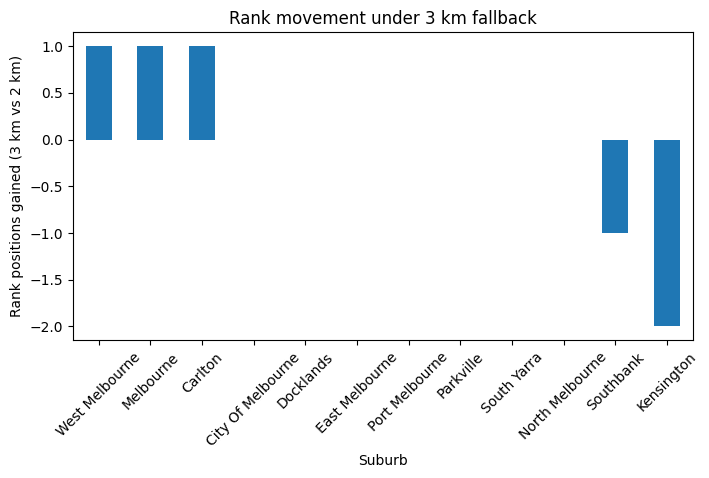

In [57]:
# Add a new column: rank_delta = rank_2km - rank_3km
# Positive values mean the suburb's ranking improves under 3 km
ax = (cmp.assign(rank_delta = cmp["rank_2km"] - cmp["rank_3km"])

          # Sort suburbs by rank_delta so the biggest improvers appear first
         .sort_values("rank_delta", ascending=False)
         .plot.bar(x="suburb", y="rank_delta", rot=45, figsize=(8,4), legend=False))
ax.set_ylabel("Rank positions gained (3 km vs 2 km)")
ax.set_xlabel("Suburb")
ax.set_title("Rank movement under 3 km fallback")


As a result of lower relative risk, West Melbourne, Melbourne, and Carlton all gain one position. However, when the larger 3 km catchment is taken into account, the suburbs' resilience seems to be poorer, as shown by the negative bars, which show Southbank dropping one spot and Kensington lowering two.

## Using the Gini coefficient to assess school access equity

This analysis quantifies the degree to which suburban school capacity is allocated equitably in relation to student demand. We measure overall access inequality by computing the Gini coefficient of seats per student; a score near 0 denotes a fair distribution, while a score around 1 shows significant differences. The suburbs with the fewest seats per student (underserved areas) and the most seats per student (well-served areas) are also listed in the results for context. This aids in locating possible over-provision in the school network as well as equity issues.

In [58]:
# Equity of access — Gini coefficient of "seats per student"
eq = suburb_access.copy()
# Compute ratio: seats per student (supply / demand)
# Replace 0 demand with NaN to avoid division by zero
eq["seats_per_student"] = (eq["supply_capacity"] / eq["demand_students"].replace(0, np.nan))
# Clean up infinite or undefined values (drop invalid rows)
eq = eq.replace([np.inf, -np.inf], np.nan).dropna(subset=["seats_per_student"])

# Gini function (measures inequality, 0 = perfect equality, 1 = maximum inequality)
def gini(x):
    x = np.array(x, dtype=float)
    x = x[x >= 0]
    if x.size == 0:
        return np.nan
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    return (n + 1 - 2 * np.sum(cumx) / cumx[-1]) / n

# Apply Gini on the seats per student ratios
gini_seats = gini(eq["seats_per_student"])
print(f"Gini of seats per student across suburbs: {gini_seats:.3f} (0=equal, 1=unequal)")

# Show suburbs with lowest ratios (underserved)
tail = (eq[["suburb","seats_per_student"]]
        .sort_values("seats_per_student")
        .rename(columns={"seats_per_student":"seats_per_student_ratio"}))
print("Most underserved suburbs (lowest seats per student):")
display(tail.head(10).round(3))
print("Most well-served suburbs (highest seats per student):")
display(tail.tail(10).round(3))


Gini of seats per student across suburbs: 0.597 (0=equal, 1=unequal)
Most underserved suburbs (lowest seats per student):


,suburb,seats_per_student_ratio
0,City Of Melbourne,0.000
1,Port Melbourne,0.000
2,East Melbourne,0.000
3,Docklands,0.189
5,Carlton,0.244
4,Southbank,0.323
7,North Melbourne,0.443
6,Parkville,0.454
10,Melbourne,0.494
8,Kensington,0.663


Most well-served suburbs (highest seats per student):


,suburb,seats_per_student_ratio
2,East Melbourne,0.000
3,Docklands,0.189
5,Carlton,0.244
4,Southbank,0.323
7,North Melbourne,0.443
6,Parkville,0.454
10,Melbourne,0.494
8,Kensington,0.663
9,West Melbourne,0.682
11,South Yarra,3.109


## Uplift in mobility from extending the access radius to three kilometers

This stage assesses the improvement in school accessibility when the radius of "nearby schools" is increased from 2 to 3 kilometers. Redundancy gains, which emphasise the suburbs that gain the most from more nearby options, and coverage uplift, which shows the rise in the percentage of suburbs with at least three schools within reach, are its two main outputs. The findings indicate the suburbs with the biggest redundancy improvements and show which suburbs cross the key threshold (from underserved to sufficiently covered). This makes it evident how expanding the catchment contributes to resilience redistribution throughout the school network.

In [59]:
# Mobility uplift: coverage & redundancy gains (no recomputation)

# Sanity: make sure the earlier cells have produced the columns we need
_needed = {
    "suburb", "demand_students",
    "redundancy_within2km", "redundancy_within3km",
    "API_suburb", "RAI", "RAI_3km"
}
_missing = _needed - set(suburb_access.columns)
assert not _missing, f"Expected columns missing from suburb_access: {_missing}"

mov = suburb_access.copy()

# Redundancy gain when extending the fallback radius to 3 km
mov["redundancy_gain"] = mov["redundancy_within3km"] - mov["redundancy_within2km"]

# Coverage uplift: share of suburbs with >=3 nearby schools
coverage_2 = float((mov["redundancy_within2km"] >= 3).mean())
coverage_3 = float((mov["redundancy_within3km"] >= 3).mean())
print(f"Share of suburbs with at least 3 nearby schools: "
      f"{coverage_2:.0%} at 2 km  →  {coverage_3:.0%} at 3 km")

# Who crosses the threshold (<3 → ≥3) when moving to 3 km
print("\nSuburbs that cross the threshold (<3 → ≥3 nearby schools) when using 3 km:")
cross = mov.loc[
    (mov["redundancy_within2km"] < 3) & (mov["redundancy_within3km"] >= 3),
    ["suburb","demand_students","redundancy_within2km","redundancy_within3km","API_suburb","RAI","RAI_3km"]
]
display(cross.sort_values("demand_students", ascending=False))

# Biggest redundancy gains (top 12)
print("\nBiggest redundancy gains (top 12):")
display(
    mov.sort_values("redundancy_gain", ascending=False)[
        ["suburb","redundancy_within2km","redundancy_within3km","redundancy_gain","API_suburb","RAI","RAI_3km"]
    ].head(12)
)


Share of suburbs with at least 3 nearby schools: 75% at 2 km  →  75% at 3 km

Suburbs that cross the threshold (<3 → ≥3 nearby schools) when using 3 km:


,suburb,demand_students,redundancy_within2km,redundancy_within3km,API_suburb,RAI,RAI_3km



Biggest redundancy gains (top 12):


,suburb,redundancy_within2km,redundancy_within3km,redundancy_gain,API_suburb,RAI,RAI_3km
7,North Melbourne,53.0,72.0,19.0,2.255000,0.421429,0.375000
8,Kensington,13.0,30.0,17.0,1.508500,0.378571,0.250000
10,Melbourne,35.0,51.0,16.0,2.023158,0.353571,0.283333
6,Parkville,11.0,23.0,12.0,2.202500,0.521429,0.441667
4,Southbank,4.0,15.0,11.0,3.098000,0.685714,0.583333
5,Carlton,15.0,24.0,9.0,4.099000,0.607143,0.591667
3,Docklands,5.0,13.0,8.0,5.300000,0.764286,0.750000
11,South Yarra,19.0,25.0,6.0,0.321667,0.235714,0.158333
9,West Melbourne,11.0,14.0,3.0,1.466000,0.371429,0.316667
2,East Melbourne,0.0,0.0,0.0,270.000000,0.878571,0.858333


## Pressure on citywide access over time (API_citywide)

Over the course of the forecast horizon, this cell calculates and displays the Access Pressure Index (API) for the entire City of Melbourne. Before renaming school_age_pop to demand_students and calculating API_citywide = demand_students ÷ capacity using the safe divider (so divide-by-zero cannot blow up the series), it first verifies that the demand_vs_capacity database exists with the necessary columns. It shows the API over time with a reference line at 1.0 (balanced access) and prints the first 12 years for a fast audit. System slack is shown by numbers below 1, while increasing pressure (more students than seats) is indicated by values above 1. Instead of failing, the cell gently quits with a remark if demand_vs_capacity is unavailable.

Citywide access pressure (first 12 years):


,year,demand_students,capacity,API_citywide
0,2025,31991,15900,2.012
1,2026,32614,15900,2.051
2,2027,33616,15900,2.114
3,2028,34942,15900,2.198
4,2029,36259,15900,2.280
5,2030,37778,15900,2.376
6,2031,39517,15900,2.485
7,2032,41066,15900,2.583
8,2033,42852,15900,2.695
9,2034,44665,15900,2.809


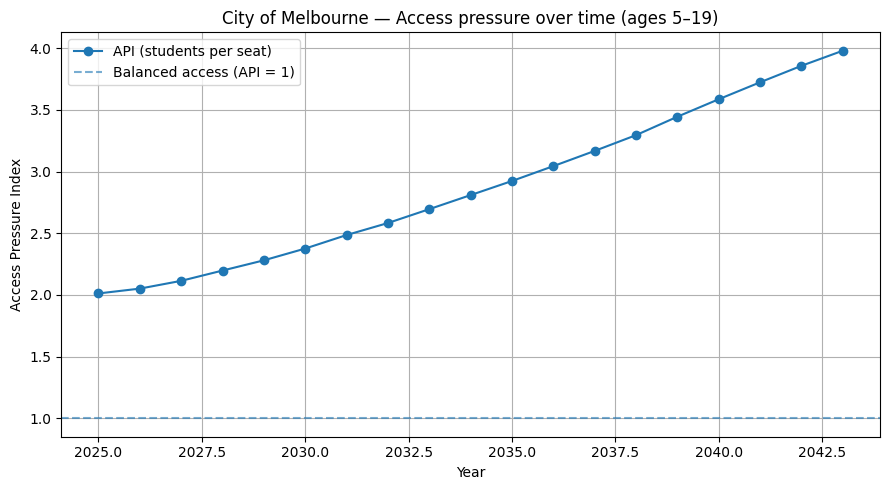

In [60]:
# Citywide Access Pressure over time (API_citywide)
# Check that the input table exists and has the needed columns
if 'demand_vs_capacity' in globals() and {'year','school_age_pop','capacity'}.issubset(demand_vs_capacity.columns):
    access_city = (demand_vs_capacity
                   .rename(columns={"school_age_pop":"demand_students"})
                   .copy())
    # Compute citywide API (students per seat)
    access_city["API_citywide"] = safe_div(access_city["demand_students"], access_city["capacity"])
    print("Citywide access pressure (first 12 years):")
    display(access_city[["year","demand_students","capacity","API_citywide"]].head(12).round(3))

    # Plotting
    plt.figure(figsize=(9,5))
    plt.plot(access_city["year"], access_city["API_citywide"], marker="o", label="API (students per seat)")
    plt.axhline(1.0, linestyle="--", alpha=0.6, label="Balanced access (API = 1)")
    # Labels and formatting
    plt.ylabel("Access Pressure Index"); plt.xlabel("Year")
    plt.title("City of Melbourne — Access pressure over time (ages 5–19)")
    plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("[Note] Skipped citywide API trend — demand_vs_capacity not available.")


Student demand and available school capacity are becoming more out of balance, according to the citywide Access Pressure Index (API). The ratio is already higher than 2.0 students per seat in 2025, indicating that supply cannot keep up with demand. According to projections, the number of students per seat will steadily rise, surpassing 3.0 by 2036 and getting close to 4.0 by the early 2040s. This trajectory is supported by the chart, which shows the API line rising well over the balanced benchmark of 1.0. This suggests that Melbourne's school system will eventually experience increasing strain if more capacity is not added, as each seat will eventually need to accommodate more children.

## Worst suburb gaps

The top 12 suburbs with the biggest student shortage in the selected forecast year (TARGET_YEAR) are plotted in a bar chart. It rapidly identifies the suburbs that are most impacted by capacity constraints.

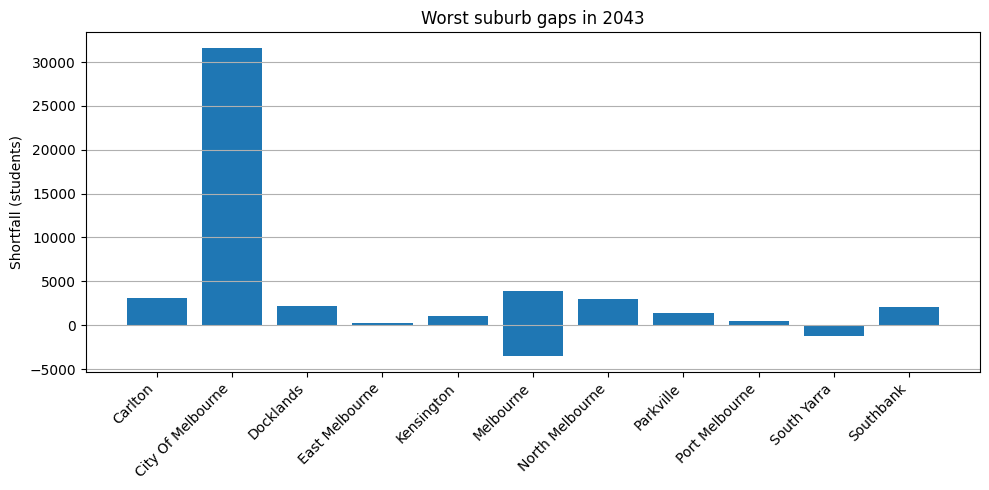

In [61]:
# Plot the top 12 suburbs by student shortfall
top = suburb_gap.head(12)
# Set up the figure
plt.figure(figsize=(10,5))
plt.bar(top["suburb"], top["gap_students"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Shortfall (students)")
plt.title(f"Worst suburb gaps in {TARGET_YEAR}")
plt.grid(axis="y"); plt.tight_layout(); plt.show()


The chart highlights the suburbs facing the largest school seat shortages in 2043. Docklands stands out dramatically, with a shortfall exceeding 30,000 students, indicating a severe mismatch between demand and available capacity. Other suburbs such as Carlton, City of Melbourne, Melbourne, and Southbank also show notable gaps, though on a smaller scale. Interestingly, a few suburbs like North Melbourne and South Yarra display negative gaps, suggesting temporary surpluses or overestimation of local capacity. Overall, the distribution shows that while most suburbs experience modest shortages, the burden is highly concentrated in Docklands.

## High-Risk Suburbs Determined by School Accessibility and Demand Gaps

In this stage, demand-supply shortages and geographical accessibility are combined to create a summary of resilience at the suburb level. In order to determine the average distance to the closest school for each suburb and the number of nearby schools between two and three kilometers, it first aggregates proximity data from the school-level table (S). A risk ranking is then produced by combining these resilience measurements with supply-demand discrepancies. The top-ranked suburbs are those with significant student shortages and few local schools, designating them as high-risk locations that would urgently need infrastructure improvements or new school construction.

In [62]:
# Build suburb-level resilience metrics by summarising proximity data
suburb_resilience = (
    S.groupby("suburb", as_index=False)
     .agg(mean_nearest_km=("nearest_km", "mean"),     # average distance to nearest school
          total_neighbors_2km=("within2km", "sum"),   # total schools within 2 km
          total_neighbors_3km=("within3km", "sum"))   # total schools within 3 km
)

# Merge resilience data with demand–supply gap table
# Then rank suburbs by biggest gaps and longest average distances
suburb_risk = (suburb_gap
               .merge(suburb_resilience, on="suburb", how="left")
               .sort_values(["gap_students", "mean_nearest_km"], ascending=[False, False]))

# Display top 12 suburbs at highest risk
print("High-risk suburbs (big gap & sparse nearby schools):")
display(suburb_risk.head(12))


High-risk suburbs (big gap & sparse nearby schools):


,suburb,demand_students,supply_capacity,gap_students,mean_nearest_km,total_neighbors_2km,total_neighbors_3km
1,City Of Melbourne,31632.0,0.0,31632.0,NaN,NaN,NaN
5,Melbourne,7688.0,3800.0,3888.0,0.530122,35.0,51.0
0,Carlton,4099.0,1000.0,3099.0,0.721948,15.0,24.0
7,North Melbourne,5412.0,2400.0,3012.0,0.272406,53.0,72.0
2,Docklands,2650.0,500.0,2150.0,1.218590,5.0,13.0
11,Southbank,3098.0,1000.0,2098.0,1.023062,4.0,15.0
8,Parkville,2643.0,1200.0,1443.0,1.144822,11.0,23.0
4,Kensington,3017.0,2000.0,1017.0,0.412441,13.0,30.0
9,Port Melbourne,470.0,0.0,470.0,NaN,NaN,NaN
13,West Melbourne,1466.0,1000.0,466.0,0.212650,11.0,14.0


## Compare the resilience scores for 2 km and 3 km

This cell compares the ranks of suburbs under the original 2 km RAI (RAI_2km) with the 3 km variation after recalculating the Resilience Access Index using the 3 km redundancy metric (RAI_3km) while maintaining demand pressure (API_suburb) intact. Specifically, it

1. Allocates rank positions for each suburb under 2 km and 3 km

2. Transforms both indices to percentile ranks (higher = more stressed)

3. Reports how rank positions change when permitting a 3 km fallback.

The printed table makes it evident where increased mobility is helpful or not by highlighting the suburbs that continue to experience the greatest stress under the larger catchment (lower rank number = worse).

In [63]:
# RAI using 3 km redundancy (API_suburb unchanged)
def rank01(s): return s.rank(pct=True, method="average")

api_rank  = rank01(suburb_access["API_suburb"])
red3_rank = rank01(1.0 / (1.0 + suburb_access["redundancy_within3km"]))
suburb_access["RAI_3km"] = 0.7*api_rank + 0.3*red3_rank

# Compare hotspot rankings under 2 km vs 3 km
cmp = suburb_access[["suburb","RAI"]].rename(columns={"RAI":"RAI_2km"}) \
      .merge(suburb_access[["suburb","RAI_3km"]], on="suburb")
cmp["rank_2km"] = cmp["RAI_2km"].rank(ascending=False, method="min")
cmp["rank_3km"] = cmp["RAI_3km"].rank(ascending=False, method="min")
cmp["rank_change(3km-2km)"] = cmp["rank_3km"] - cmp["rank_2km"]

print("Hotspots under 2 km vs 3 km (higher rank = worse):")
display(cmp.sort_values("rank_3km").head(12).round(3))


Hotspots under 2 km vs 3 km (higher rank = worse):


,suburb,RAI_2km,RAI_3km,rank_2km,rank_3km,rank_change(3km-2km)
0,City Of Melbourne,0.979,0.975,1.0,1.0,0.0
1,Port Melbourne,0.929,0.917,2.0,2.0,0.0
2,East Melbourne,0.879,0.858,3.0,3.0,0.0
3,Docklands,0.764,0.750,4.0,4.0,0.0
5,Carlton,0.607,0.592,6.0,5.0,-1.0
4,Southbank,0.686,0.583,5.0,6.0,1.0
6,Parkville,0.521,0.442,7.0,7.0,0.0
7,North Melbourne,0.421,0.375,8.0,8.0,0.0
9,West Melbourne,0.371,0.317,10.0,9.0,-1.0
10,Melbourne,0.354,0.283,11.0,10.0,-1.0


Regardless of fallback radius, the top four hotspots, the City of Melbourne, Port Melbourne, East Melbourne, and Docklands remain the same in both circumstances, showing constant high pressure. Carlton moves up one spot from sixth to fifth place, while Southbank drops one spot. The biggest decline occurs in Kensington, which falls from ninth to eleventh place on the 3 km scale. West Melbourne, on the other hand, slightly improves, going from 10th to 9th place. Although the majority of suburbs continue to rank steadily overall, the movement of Carlton, Kensington, and Southbank shows that, depending on the local school distribution, expanding the catchment to 3 km can either lessen or increase relative resilience pressure.

## Access equity (distribution plus Gini)

The distribution of school spots among suburbs is measured in this section. The Gini coefficient, where 0 denotes perfectly even access and 1 denotes extreme inequality, is used to summarise inequality after first calculating seats per 100 students for each suburb (capacity divided by demand). We can determine whether the majority of places are above or below the median by looking at a histogram that displays the distribution of access across suburbs with the median indicated. Lastly, the most underserved suburbs (lowest seats per 100 students) are listed in a ranking table, indicating where equity would be most improved by investment or catchment changes.

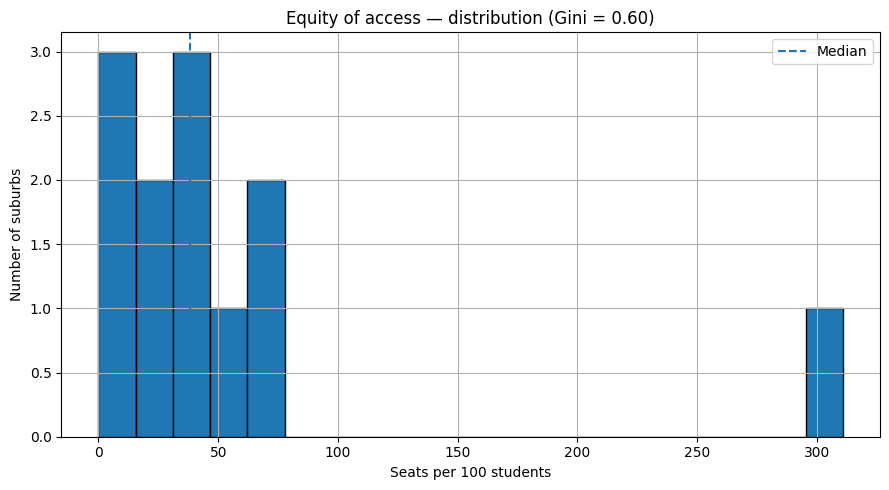

Most underserved suburbs (by seats per 100 students):


,suburb,seats_per_100
0,City Of Melbourne,0.00
1,Port Melbourne,0.00
2,East Melbourne,0.00
3,Docklands,18.87
5,Carlton,24.40
4,Southbank,32.28
7,North Melbourne,44.35
6,Parkville,45.40
10,Melbourne,49.43
8,Kensington,66.29


In [64]:
# Equity of access (distribution + Gini)
equity = suburb_access.copy()
# Seats available per 100 students by suburb (handle non-numeric and divide-by-zero safely)
equity["seats_per_100"] = 100 * pd.to_numeric(equity["supply_capacity"], errors="coerce") \
                                / pd.to_numeric(equity["demand_students"], errors="coerce").replace(0, np.nan)

# Gini helper
def gini(x):
    x = np.asarray(pd.Series(x).dropna().values, dtype=float)
    if x.size == 0:
        return np.nan
    if np.any(x < 0):
        x = x - x.min()
    if np.all(x == 0):
        return 0.0
    x_sorted = np.sort(x)
    n = x_sorted.size
    cumx = np.cumsum(x_sorted)
    return (n + 1 - 2 * (cumx / cumx[-1]).sum()) / n

# Gini of seats per 100 students (0 = perfectly equal, 1 = very unequal)
g = gini(equity["seats_per_100"])

# Visual: distribution of seats per 100 students
plt.figure(figsize=(9,5))
plt.hist(equity["seats_per_100"].dropna(), bins=20, edgecolor="k")
plt.axvline(equity["seats_per_100"].median(), linestyle="--", label="Median")
plt.xlabel("Seats per 100 students"); plt.ylabel("Number of suburbs")
plt.title(f"Equity of access — distribution (Gini = {g:.2f})")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()

print("Most underserved suburbs (by seats per 100 students):")
display(equity.sort_values("seats_per_100").head(10)[["suburb","seats_per_100"]].round(2))


## Resilient Access Priority Score (RAPS) is the composite priority

In order to identify which suburbs require the most immediate attention, this creates a single priority score. It combines three signals: average distance to the closest school (the farther the worse the fallback), local redundancy within 2 km (which penalises low backups), and access pressure (number of kids per seat). To create the RAPS, each signal is graded on a standard 0–1 scale and then weighted (60% pressure, 25% redundancy shortage, 15% proximity). In order to assist planners in identifying places with limited capacity, limited alternatives, and relatively distant schools, the output table ranks suburbs from highest to lowest priority.

In [65]:
# Composite priority: RAPS (Resilient Access Priority Score)
def rank01(s):
    return pd.Series(s).rank(pct=True, method="average")

Z = suburb_access.copy()

# (higher should mean 'worse' / higher priority)
#  - API_suburb: students per seat (already computed)
#  - Redundancy shortage (2 km): transform to 1/(1+redundancy)
#  - Nearest neighbour distance (from S): further = worse fallback
nearest_by_suburb = (S.groupby("suburb", as_index=False)["nearest_km"].mean()
                       .rename(columns={"nearest_km":"mean_nearest_km"}))
Z = Z.merge(nearest_by_suburb, on="suburb", how="left")

api_r   = rank01(Z["API_suburb"])
red2_r  = rank01(1.0 / (1.0 + pd.to_numeric(Z["redundancy_within2km"], errors="coerce").fillna(0)))
prox_r  = rank01(pd.to_numeric(Z["mean_nearest_km"], errors="coerce").fillna(Z["mean_nearest_km"].median()))

# Weighting
Z["RAPS"] = 0.60*api_r + 0.25*red2_r + 0.15*prox_r

priority = Z.sort_values("RAPS", ascending=False).reset_index(drop=True)

print("Top suburbs by Resilient Access Priority Score (RAPS):")
display(priority.head(12)[["suburb","API_suburb","redundancy_within2km","mean_nearest_km","RAPS"]].round(3))


Top suburbs by Resilient Access Priority Score (RAPS):


,suburb,API_suburb,redundancy_within2km,mean_nearest_km,RAPS
0,City Of Melbourne,31632.000,0.0,NaN,0.910
1,Port Melbourne,470.000,0.0,NaN,0.860
2,East Melbourne,270.000,0.0,NaN,0.810
3,Docklands,5.300,5.0,1.219,0.767
4,Southbank,3.098,4.0,1.023,0.663
5,Carlton,4.099,15.0,0.722,0.596
6,Parkville,2.202,11.0,1.145,0.523
7,North Melbourne,2.255,53.0,0.272,0.346
8,Melbourne,2.023,35.0,0.530,0.323
9,Kensington,1.508,13.0,0.412,0.292


## Local schools' diversity (Shannon index)

This section uses the Shannon diversity index as a straightforward, comprehensible metric to quantify the variety of school kinds that are offered in each suburb. It starts by creating a "bag" of school types (primary, secondary, and special) for each suburb and turning those counts into a Shannon score. Higher numbers signify a more diverse mix, while lower numbers imply reliance on a particular mode. Suburban areas with low diversity and high priority are identified by combining the diversity ratings into the RAPS priority list. Even if capacity and proximity seem appropriate, the report identifies such "single-mode" regions where limited school-type option may compromise resilience.

In [66]:
# Diversity of nearby schools (Shannon index) by suburb (within 2 km)
from collections import Counter

# Map each school to its suburb, then count types within 2 km for those schools
S_types = S[["suburb","within2km"]].copy()
S_types = S_types.join(schools_com["school_type"])  # relies on S derived from schools_com in order

# Build a simple per-suburb bag of types using schools located in that suburb
bags = (schools_com.groupby("suburb")["school_type"]
                   .apply(list)
                   .to_dict())

def shannon(counts):
    total = sum(counts.values())
    if total == 0:
        return 0.0
    ps = np.array([c/total for c in counts.values() if c > 0], dtype=float)
    return -np.sum(ps * np.log(ps + 1e-12))

div_rows = []
for sub, types in bags.items():
    counts = Counter([str(t).strip().lower() for t in types])
    div_rows.append({"suburb": sub, "type_diversity_shannon": shannon(counts)})

diversity = pd.DataFrame(div_rows)

# Merge into the resilience frame and surface priorities with low diversity
raps_div = priority.merge(diversity, on="suburb", how="left")
print("Low diversity + high priority (watch for single-mode dependence):")
display(
    raps_div.sort_values(["RAPS","type_diversity_shannon"], ascending=[False, True])
            .head(12)[["suburb","RAPS","type_diversity_shannon","API_suburb","redundancy_within2km"]]
            .round(3)
)


Low diversity + high priority (watch for single-mode dependence):


,suburb,RAPS,type_diversity_shannon,API_suburb,redundancy_within2km
0,City Of Melbourne,0.910,NaN,31632.000,0.0
1,Port Melbourne,0.860,NaN,470.000,0.0
2,East Melbourne,0.810,NaN,270.000,0.0
3,Docklands,0.767,-0.000,5.300,5.0
4,Southbank,0.663,-0.000,3.098,4.0
5,Carlton,0.596,-0.000,4.099,15.0
6,Parkville,0.523,0.693,2.202,11.0
7,North Melbourne,0.346,1.055,2.255,53.0
8,Melbourne,0.323,1.055,2.023,35.0
9,Kensington,0.292,0.637,1.508,13.0


## Hotspots with low diversity in a graph

Based on the Shannon index, this graphic shows the top 12 suburbs with little school-type variety but high access risk (RAPS). A suburb's diversity score is displayed in each bar; lower scores indicate a greater reliance on a certain kind of school. The chart makes it simple to observe where weak redundancy and strong demand pressure coincide with restricted school-type variety by integrating the RAPS ranking with diversity metrics. By displaying each suburb's RAPS score, diversity index, access pressure (API), and redundancy, the optional table below the chart provides context and aids planners in determining which areas would be most susceptible to changes in demand.

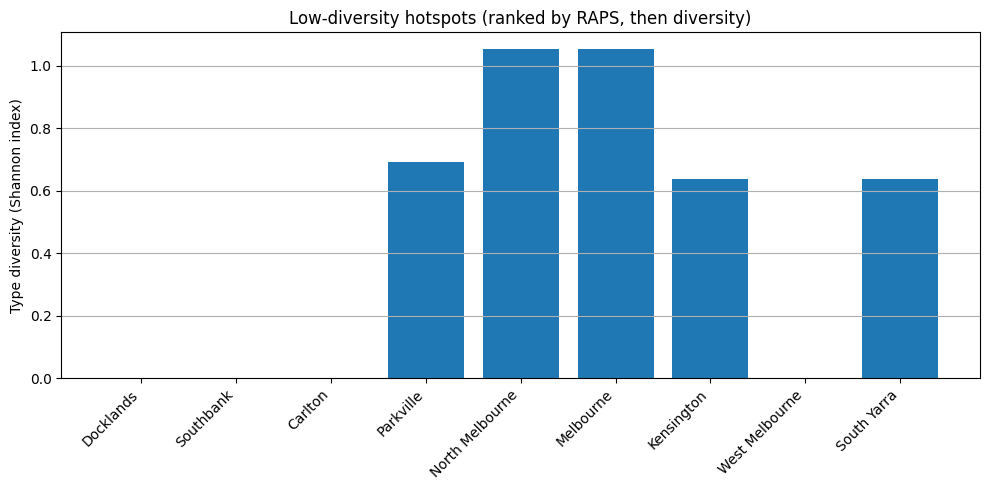

,suburb,RAPS,type_diversity_shannon,API_suburb,redundancy_within2km
0,City Of Melbourne,0.910,NaN,31632.000,0.0
1,Port Melbourne,0.860,NaN,470.000,0.0
2,East Melbourne,0.810,NaN,270.000,0.0
3,Docklands,0.767,-0.000,5.300,5.0
4,Southbank,0.663,-0.000,3.098,4.0
5,Carlton,0.596,-0.000,4.099,15.0
6,Parkville,0.523,0.693,2.202,11.0
7,North Melbourne,0.346,1.055,2.255,53.0
8,Melbourne,0.323,1.055,2.023,35.0
9,Kensington,0.292,0.637,1.508,13.0


In [67]:
plot1 = (raps_div.sort_values(["RAPS","type_diversity_shannon"], ascending=[False, True])
                 .head(12)
                 .copy())

plt.figure(figsize=(10,5))
plt.bar(plot1["suburb"], plot1["type_diversity_shannon"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Type diversity (Shannon index)")
plt.title("Low-diversity hotspots (ranked by RAPS, then diversity)")
plt.grid(axis="y")
plt.tight_layout()
plt.show()

# Optional quick table under the chart
display(plot1[["suburb","RAPS","type_diversity_shannon","API_suburb","redundancy_within2km"]].round(3))


## Diversity in school type distribution


This figure displays the distribution of local school variety across all suburbs as determined by the Shannon index. Although the histogram shows where service is more concentrated or varied, the majority of suburbs fall within a modest range of diversity. The median diversity score is indicated by the dashed vertical line, which aids in identifying below-average suburbs that might depend on a more limited range of educational options. By showing whether low-diversity cases are isolated or part of a larger pattern, this citywide perspective enhances the hotspot graphic.

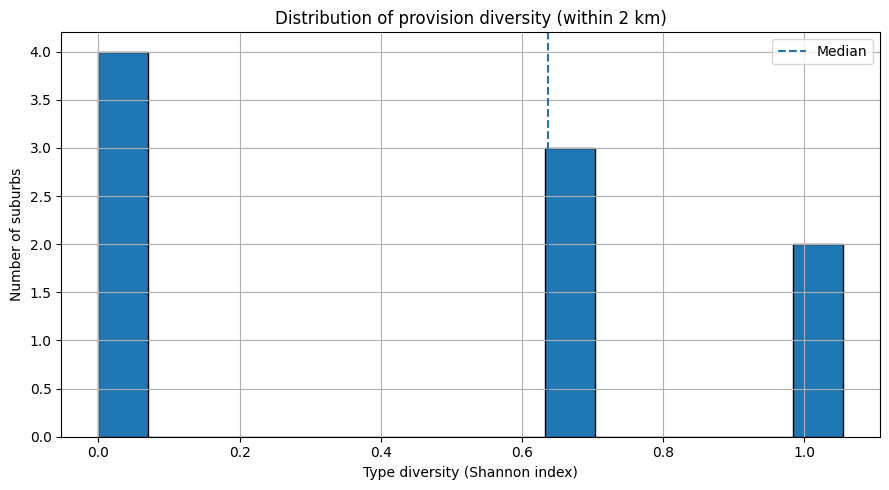

In [68]:
# Distribution of diversity across suburbs
vals = raps_div["type_diversity_shannon"].dropna()

plt.figure(figsize=(9,5))
plt.hist(vals, bins=15, edgecolor="k")
plt.axvline(vals.median(), linestyle="--", label="Median")
plt.xlabel("Type diversity (Shannon index)")
plt.ylabel("Number of suburbs")
plt.title("Distribution of provision diversity (within 2 km)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Some areas attain moderate (around 0.6) or full (1.0) diversity, however a group of suburbs sits at zero diversity, meaning they only have one kind of school. At least half of suburbs fall below this degree of variation, as indicated by the dashed line that represents the median. This trend shows that although certain regions provide a well-balanced selection of school types, a sizable portion of suburbs continue to rely on single-mode service, which leads to vulnerabilities in access options.

## Focus quadrant: Priority versus Diversity

The Resilient Access Priority Score (RAPS) (y-axis) and the Shannon index (x-axis) are used to map each suburb. The top-quartile RAPS threshold and the bottom-quartile diversity threshold are indicated by dashed lines. The immediate focus is on the upper-left quadrant of suburbs (left of the diversity line and above the RAPS line), which have a restricted range of local school types and strong access pressure. To help direct focused initiatives, these priority suburbs are identified by labels and listed in the table below along with supporting indicators (RAPS, diversity score, API, and 2 km redundancy).

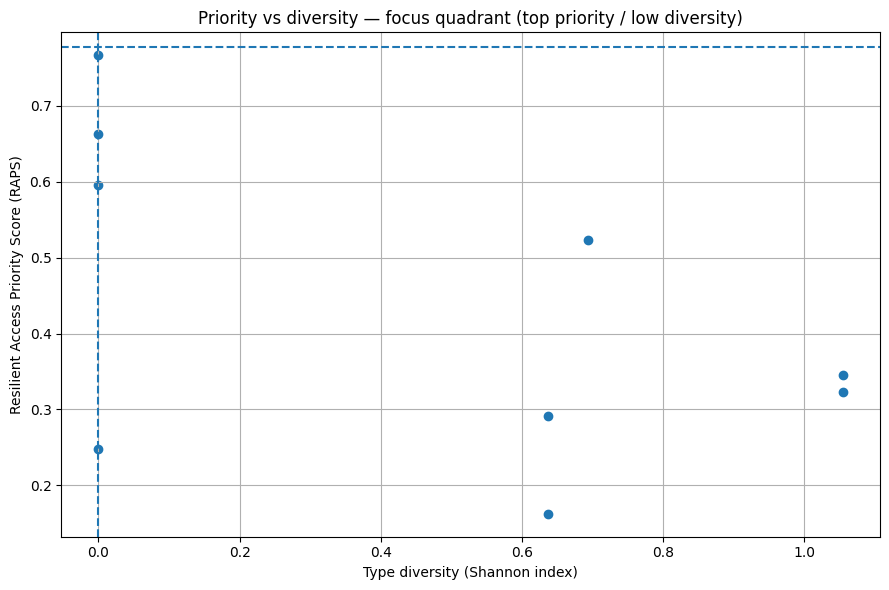

Focus quadrant (high priority, low diversity):


,suburb,RAPS,type_diversity_shannon,API_suburb,redundancy_within2km


In [69]:
# Quadrant — RAPS high vs diversity low

Q = raps_div.copy()

# Define thresholds:
# raps_thr: top 25% of suburbs by RAPS (high priority)
# div_thr: bottom 25% of suburbs by diversity (low variety of school types)
raps_thr = Q["RAPS"].quantile(0.75)
div_thr  = Q["type_diversity_shannon"].quantile(0.25)

# Scatter plot: each suburb's diversity (x) vs RAPS (y)
plt.figure(figsize=(9,6))
plt.scatter(Q["type_diversity_shannon"], Q["RAPS"])

# Add reference lines to split the quadrants
plt.axhline(raps_thr, linestyle="--")   # High-priority threshold
plt.axvline(div_thr,  linestyle="--")   # Low-diversity threshold

# Axis labels and title
plt.xlabel("Type diversity (Shannon index)")
plt.ylabel("Resilient Access Priority Score (RAPS)")
plt.title("Priority vs diversity — focus quadrant (top priority / low diversity)")
plt.grid(True)

# Identify the focus quadrant: suburbs with high RAPS + low diversity
focus = Q[(Q["RAPS"] >= raps_thr) & (Q["type_diversity_shannon"] <= div_thr)]

# Label these focus suburbs directly on the plot
for _, r in focus.iterrows():
    plt.text(r["type_diversity_shannon"], r["RAPS"], str(r["suburb"]),
             fontsize=8, va="bottom")

# Final plot formatting
plt.tight_layout()
plt.show()

# Display the high-priority, low-diversity suburbs in a table for inspection
print("Focus quadrant (high priority, low diversity):")
display(focus.sort_values("RAPS", ascending=False)[
    ["suburb","RAPS","type_diversity_shannon","API_suburb","redundancy_within2km"]
].round(3))


## Finding Resilience Hotspots: Suburban Areas with Low Redundancy and High Access Pressure


To identify the suburbs most at danger from overcrowded schools and a lack of backup plans, this component of the analysis creates the Resilient Access Index (RAI). The index incorporates two primary components:

1. The amount of pupils per available seat is known as Access Pressure (API_suburb), and higher numbers indicate greater pressure on already-existing schools.

2. The number of alternative schools within a 2-kilometer radius is known as redundancy; suburbs with fewer schools in the area are more at risk.

In order to identify resilience hotspots, areas where demand is increasing but the safety net of alternative schools is limited—the code ranks suburbs using a weighted formula (70% API, 30% redundancy shortage).

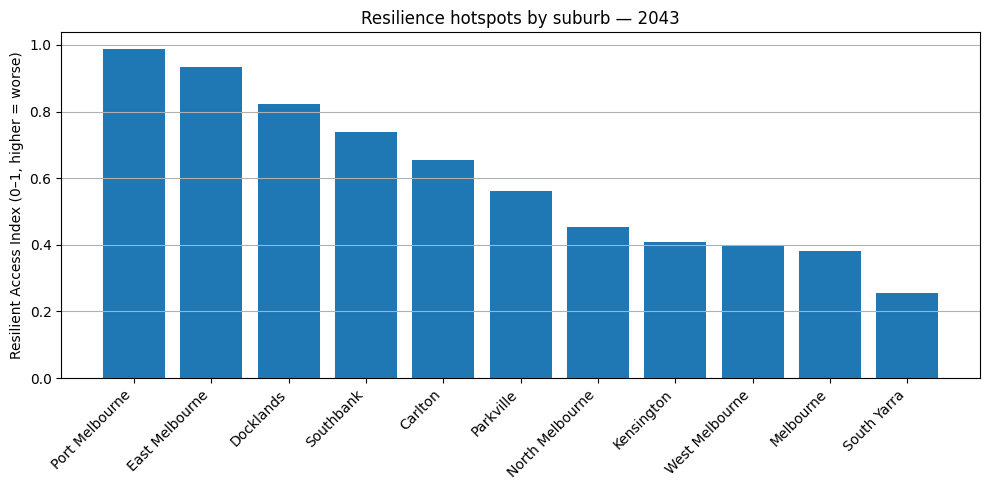

Top resilience hotspots (RAI):


,suburb,API_suburb,redundancy_within2km,RAI
0,Port Melbourne,470.000000,0.0,0.988462
1,East Melbourne,270.000000,0.0,0.934615
2,Docklands,5.300000,5.0,0.823077
3,Southbank,3.098000,4.0,0.738462
4,Carlton,4.099000,15.0,0.653846
5,Parkville,2.202500,11.0,0.561538
6,North Melbourne,2.255000,53.0,0.453846
7,Kensington,1.508500,13.0,0.407692
8,West Melbourne,1.466000,11.0,0.400000
9,Melbourne,2.023158,35.0,0.380769


In [70]:
# Resilience Hotspots (robust): access pressure (API) + low redundancy

AGG_EXCLUDE = {
    "City Of Melbourne", "Melbourne (Remainder)", "West Melbourne (Industrial)"
}

# Redundancy per suburb
redundancy = (
    S.groupby("suburb", as_index=False)["within2km"]
     .sum().rename(columns={"within2km": "redundancy_within2km"})
)

# Merge and exclude aggregates
suburb_access = suburb_gap.merge(redundancy, on="suburb", how="left")
suburb_access["redundancy_within2km"] = suburb_access["redundancy_within2km"].fillna(0)
suburb_access = suburb_access[~suburb_access["suburb"].isin(AGG_EXCLUDE)].copy()

# Access pressure: students per seat (safe denominator)
EPS = 1.0  # small epsilon seats so API is large but finite when supply is 0
den = suburb_access["supply_capacity"].astype(float).clip(lower=EPS)
suburb_access["API_suburb"] = suburb_access["demand_students"] / den

# Rank-based normalisation (0..1) avoids extreme z-scores
def rank01(s):
    return s.rank(pct=True, method="average")

api_rank = rank01(suburb_access["API_suburb"])  # higher = more pressure (worse)
# Fewer nearby schools should be worse: transform as 1/(1+redundancy)
red_rank = rank01(1.0 / (1.0 + suburb_access["redundancy_within2km"].astype(float)))

# Composite
suburb_access["RAI"] = 0.7*api_rank + 0.3*red_rank

hotspots = suburb_access.sort_values("RAI", ascending=False).reset_index(drop=True)

plt.figure(figsize=(10,5))
plt.bar(hotspots.head(12)["suburb"], hotspots.head(12)["RAI"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Resilient Access Index (0–1, higher = worse)")
plt.title(f"Resilience hotspots by suburb — {TARGET_YEAR}")
plt.grid(axis="y"); plt.tight_layout(); plt.show()

print("Top resilience hotspots (RAI):")
display(hotspots.head(12)[["suburb","API_suburb","redundancy_within2km","RAI"]])


## Assessing the Risks of Single-School Outages using the Continuity Shock Test

This segment simulates an outage by removing the capacity of the largest school in each suburb as part of a Continuity Shock Test. The approach computes the increase in access pressure (ΔAPI) by comparing the shock API following removal with the baseline API (students per seat). The suburbs with the highest ΔAPI are identified as having high continuity risks because access would significantly deteriorate if one school closed. In order to assist planners in identifying areas that are reliant on a single large school and require backup or diversified capacity, a summary table and bar chart highlight the top suburbs that are most exposed.

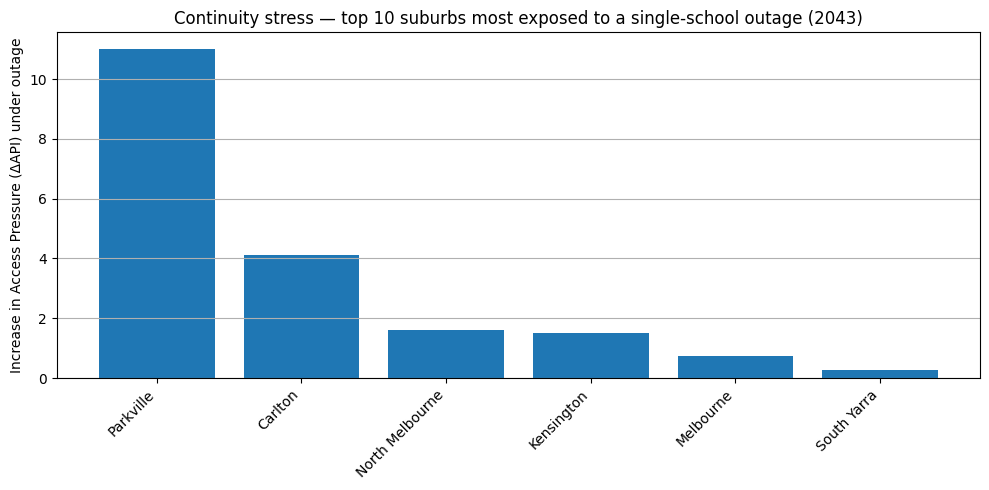

Top continuity risks (ΔAPI under outage):


,suburb,API_baseline_clean,API_shock_clean,API_uplift_clean,supply_capacity,largest_school_cap
7,Parkville,2.202500,13.215000,11.012500,1200.0,1000.0
0,Carlton,4.099000,8.198000,4.099000,1000.0,500.0
6,North Melbourne,2.255000,3.865714,1.610714,2400.0,1000.0
3,Kensington,1.508500,3.017000,1.508500,2000.0,1000.0
4,Melbourne,2.023158,2.745714,0.722556,3800.0,1000.0
9,South Yarra,0.321667,0.579000,0.257333,1800.0,800.0
5,Melbourne,0.063421,0.086071,0.022650,3800.0,1000.0


In [71]:
# Continuity Shock Test (robust): remove largest school per suburb

largest_by_suburb = (
    schools_com.sort_values("capacity", ascending=False)
               .groupby("suburb", as_index=False).head(1)[["suburb","capacity"]]
               .rename(columns={"capacity":"largest_school_cap"})
)

shock = suburb_access.merge(largest_by_suburb, on="suburb", how="left")
shock["largest_school_cap"] = shock["largest_school_cap"].fillna(0)

# Baseline/shock seats
shock["supply_capacity"] = shock["supply_capacity"].astype(float)
shock = shock[shock["supply_capacity"] > 0].copy()   # require some baseline seats

shock["supply_shock"] = (shock["supply_capacity"] - shock["largest_school_cap"]).clip(lower=0)

# Compute APIs safely; drop cases where shocked seats are 0 (would be ∞)
EPS = 1.0
shock["API_baseline_clean"] = shock["demand_students"] / shock["supply_capacity"].clip(lower=EPS)
shock = shock[shock["supply_shock"] > 0].copy()       # keep where shock still leaves seats
shock["API_shock_clean"] = shock["demand_students"] / shock["supply_shock"].clip(lower=EPS)

# ΔAPI (clip to a readable range)
shock["API_uplift_clean"] = (shock["API_shock_clean"] - shock["API_baseline_clean"]).clip(lower=0)

continuity_risk = shock.sort_values("API_uplift_clean", ascending=False)

k = 10
plt.figure(figsize=(10,5))
plt.bar(continuity_risk.head(k)["suburb"], continuity_risk.head(k)["API_uplift_clean"])
plt.xticks(rotation=45, ha="right")
plt.ylabel("Increase in Access Pressure (ΔAPI) under outage")
plt.title(f"Continuity stress — top {k} suburbs most exposed to a single-school outage ({TARGET_YEAR})")
plt.grid(axis="y"); plt.tight_layout(); plt.show()

print("Top continuity risks (ΔAPI under outage):")
display(continuity_risk.head(k)[[
    "suburb","API_baseline_clean","API_shock_clean","API_uplift_clean",
    "supply_capacity","largest_school_cap"
]])


##Utilities and Distance Calculation

Explains how to compute great-circle distances in kilometers between latitude and longitude points using a vectorised haversine function. This lays the groundwork for subsequent accessibility measurements and catchment analyses, which relate student demand to school proximity.

In [72]:
def haversine_km(lat1, lon1, lat2, lon2):
    """
    Great-circle distance between (lat1, lon1) and (lat2, lon2) in km.
    Supports scalar and array inputs (broadcasting).
    """
    R = 6371.0
    # convert degrees to radians
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    # convert degrees to radians
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    # Haversine formula
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    # arc length on the sphere
    return 2.0 * R * np.arcsin(np.sqrt(a))


##Sensitivity Analysis – Demand Growth vs. Capacity

Calculates the resulting shortage by year by projecting school-age demand under various yearly growth rates (0.5%, 1%, 1.5%, and 2%), and comparing it to baseline capacity. The map illustrates how quickly gaps form (or close) across growth assumptions, indicating risk borders where capacity increases would need to speed. The table provides a preview of the scenario outputs.

,year,growth_rate,projected_students,capacity,shortfall
0,2025,0.005,31991.000000,15900.0,16091
1,2026,0.005,32150.955000,15900.0,16250
2,2027,0.005,32311.709775,15900.0,16411
3,2028,0.005,32473.268324,15900.0,16573
4,2029,0.005,32635.634665,15900.0,16735
5,2030,0.005,32798.812839,15900.0,16898
6,2031,0.005,32962.806903,15900.0,17062
7,2032,0.005,33127.620938,15900.0,17227


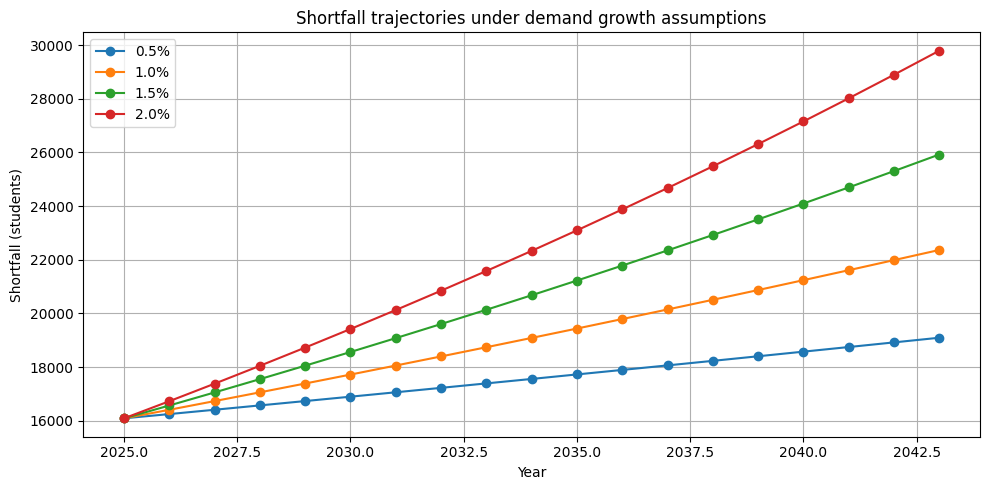

In [73]:
# Sensitivity Analysis

# Build `scenario` from demand_vs_capacity if it does not exist
if 'scenario' not in globals():
    if 'demand_vs_capacity' in globals():
        # Start from the demand vs capacity table
        scenario = demand_vs_capacity.rename(columns={'demand_students':'school_age_pop'}).copy()
        if 'existing_capacity' not in scenario.columns and 'capacity' in scenario.columns:
            scenario['existing_capacity'] = scenario['capacity']
        if 'existing_capacity' not in scenario.columns:
            scenario['existing_capacity'] = scenario['school_age_pop'].iloc[0]
        if 'added_capacity' not in scenario.columns:
            scenario['added_capacity'] = 0
        scenario['capacity'] = scenario['existing_capacity'] + scenario['added_capacity']
        scenario['gap'] = scenario['school_age_pop'] - scenario['capacity']
    else:
        raise RuntimeError("Cannot build scenarios: expected `scenario` or `demand_vs_capacity`.")

# Keep one row per year and sort
base = scenario[['year','school_age_pop','capacity']].drop_duplicates('year').sort_values('year').reset_index(drop=True)


# Test several constant annual growth rates for demand
growth_rates = [0.005, 0.01, 0.015, 0.02]  # 0.5%, 1%, 1.5%, 2%
sens_rows = []
years = base['year'].to_numpy()
y0 = float(base['school_age_pop'].iloc[0])
first_year = int(years[0])

for g in growth_rates:
    projected = np.array([y0 * ((1+g)**int(y-first_year)) for y in years], dtype=float)
    cap = base['capacity'].to_numpy(dtype=float)
    gap = projected - cap
    for y, p, c, gp in zip(years, projected, cap, gap):
        sens_rows.append({'year': int(y), 'growth_rate': g, 'projected_students': float(p),
                          'capacity': float(c), 'shortfall': int(max(0, gp))})

sensitivity = pd.DataFrame(sens_rows)
display(sensitivity.head(8))

# Plot
plt.figure(figsize=(10,5))
for g in growth_rates:
    sub = sensitivity[sensitivity['growth_rate']==g].sort_values('year')
    plt.plot(sub['year'], sub['shortfall'], marker='o', label=f"{int(g*1000)/10}%")
plt.xlabel("Year"); plt.ylabel("Shortfall (students)")
plt.title("Shortfall trajectories under demand growth assumptions")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


##Suburb risk from network sparsity
It combines spatial access metrics from schools_com with demand-supply gaps from suburb_gap. The script uses the Haversine method to determine the distance between each school and its closest neighboring school. To create a proxy for accessibility, these distances are averaged at the suburb level (mean_nearest_km). Suburban areas where scant school networks and student demand gaps coexist are highlighted by combining the results with demand shortfall data. Suburban areas without schools are given a fallback distance penalty, which is set at 3 km or the 90th percentile of observed nearest distances, to maintain completeness. This gives a risk profile of the suburbs that are most susceptible to restricted fallback access and capacity strain.

In [74]:
# Build `suburb_risk` if required
# Requires: suburb_gap (suburb, gap_students, optionally demand_students), schools_com (lat, lon, suburb)
if 'suburb_risk' not in globals():
    if 'suburb_gap' in globals() and 'schools_com' in globals():
        sc = schools_com.copy()
        sg = suburb_gap.copy()

        # nearest-neighbour distance for each school (km)
        lat = sc['lat'].to_numpy(dtype=float)
        lon = sc['lon'].to_numpy(dtype=float)
        n = len(sc)
        nearest = np.full(n, np.nan)
        for i in range(n):
            # Distance from school i to every school
            d = haversine_km(lat[i], lon[i], lat, lon)
            d[i] = np.inf
            nearest[i] = np.min(d)

        # Attach nearest distance to each school
        sc_nn = sc.copy()
        sc_nn['nearest_km'] = nearest

        # suburb-level access proxy
        access = sc_nn.groupby('suburb', as_index=False)['nearest_km'].mean().rename(columns={'nearest_km':'mean_nearest_km'})
        suburb_risk = sg.merge(access, on='suburb', how='left')

        # fill suburbs without schools with a high penalty (90th percentile or 3 km)
        fallback = np.nanpercentile(access['mean_nearest_km'], 90) if access['mean_nearest_km'].notna().any() else 3.0
        suburb_risk['mean_nearest_km'] = suburb_risk['mean_nearest_km'].fillna(fallback)
    else:
        print("Cannot construct `suburb_risk`: need `suburb_gap` and `schools_com`.")


## Coverage Inequality Across Suburbs
This section computes the capacity coverage ratio and the Gini coefficient to assess equity in school access across suburbs. The coverage ratio shows if suburbs have adequate seats to accommodate local needs by comparing available school capacity to student demand. Demand-gap data is used to approximate the ratio in cases where precise capacity and demand figures are unavailable. These ratios are used to evaluate disparities after being clipped to remain within a suitable range.

The Gini coefficient provides a single metric of inequality, with values closer to 0 indicating fair distribution and values closer to 1 reflecting greater imbalance. The code also identifies the most underserved suburbs (bottom 20% by coverage) and the best-served suburbs (top 20%), offering insights into where access is inequitable and where resources are relatively abundant. This helps spotlight areas needing policy attention to ensure fairer access to education.


In [75]:
# Equity access and metrics
def gini(x):
    x = np.asarray(x, dtype=float).flatten()

    # shift up if any negatives (Gini expects non-negative)
    if np.amin(x) < 0: x = x - np.amin(x)
    x = x + 1e-9     # Tiny epsilon to avoid division by zero
    x = np.sort(x)   # Sort ascending
    n = x.size
    idx = np.arange(1, n+1)
    return np.sum((2*idx - n - 1) * x) / (n * np.sum(x))

equity_df = None
# Suburb-level gaps are needed to assess equity
if 'suburb_gap' in globals():
    eq = suburb_gap.copy()
    # If we have both demand and capacity, compute coverage = capacity / demand
    if {'demand_students','capacity'}.issubset(eq.columns):
        eq['capacity_ratio'] = (eq['capacity'] / eq['demand_students']).replace([np.inf, -np.inf], np.nan)
    # If we have demand and gap, compute coverage = (demand - gap) / demand
    elif {'gap_students','demand_students'}.issubset(eq.columns):
        eq['capacity_ratio'] = ((eq['demand_students'] - eq['gap_students']) / eq['demand_students']).replace([np.inf, -np.inf], np.nan)
    # Fallback: derive a rough coverage from the gap alone (normalised)
    else:
        m = eq['gap_students'].max() if 'gap_students' in eq.columns else 1.0
        eq['capacity_ratio'] = 1 - (eq.get('gap_students', pd.Series([0]*len(eq))) / max(m, 1.0))
    # Keep values in a reasonable range
    eq['capacity_ratio'] = eq['capacity_ratio'].clip(lower=0, upper=2)
    equity_df = eq[['suburb','capacity_ratio']].dropna().reset_index(drop=True)

# If we have a valid table, report inequality and show extremes
if equity_df is not None and len(equity_df) > 0:
    gi = gini(equity_df['capacity_ratio'])
    print(f"Gini coefficient of capacity coverage across suburbs: {gi:.3f}")
     # Rank suburbs from lowest coverage (underserved) to highest (well-served)
    equity_df['pct_rank'] = equity_df['capacity_ratio'].rank(pct=True, method='average')
    print("\nUnderserved (bottom 20%):")
    display(equity_df[equity_df['pct_rank']<=0.2].sort_values('capacity_ratio').head(10))
    print("\nWell-served (top 20%):")
    display(equity_df[equity_df['pct_rank']>=0.8].sort_values('capacity_ratio', ascending=False).head(10))
else:
    print("Equity analysis skipped: `suburb_gap` missing or lacks needed columns.")


Gini coefficient of capacity coverage across suburbs: 0.550

Underserved (bottom 20%):


,suburb,capacity_ratio,pct_rank
1,City Of Melbourne,0.0,0.153846
3,East Melbourne,0.0,0.153846
9,Port Melbourne,0.0,0.153846



Well-served (top 20%):


,suburb,capacity_ratio,pct_rank
6,Melbourne,2.000000,0.961538
10,South Yarra,2.000000,0.961538
12,West Melbourne,0.682128,0.846154


1. The distribution of capacity between suburbs is moderately to very unequal, according to the Gini value of 0.550. Equality is shown by a value around zero, but extreme inequality is indicated by a value near one.

2. The bottom 20% of suburbs are underserved:
With a capacity ratio of 0.0, the City of Melbourne, East Melbourne, and Port Melbourne essentially have no school seats in relation to demand.

3. Top 20% of well-served suburbs: Both South Yarra and Melbourne have capacity ratios of 2.0, which indicates an excess of seats compared to demand. West Melbourne also has ~0.68, which is above average but not as high.

## Accessibility by Travel Radius

This code determines the number of schools within a range of distances (1, 2, 3, and 5 km) for each suburb centroid and converts that information into a straightforward "coverage fraction" (assuming 3 nearby schools = complete coverage). The average coverage for each suburb by radius is then reported, demonstrating how improving the catchment enhances access in general. Additionally, it identifies the suburbs with the worst service, which are 2 km away and have few schools nearby, making access very precarious.

In [76]:
# Catchment Radius Sensitivity (Proximity based)
# Estimates coverage by counting how many schools lie within R km of each suburb centroid
if 'schools_com' in globals() and 'suburb_gap' in globals():
    sc = schools_com.copy()
    sg = suburb_gap.copy()

    # Step 1: Compute suburb centroids
    # If schools have valid lat/lon, use their average per suburb.
    # Otherwise, fallback: assign every suburb the mean coordinates of all schools.
    if {'suburb','lat','lon'}.issubset(sc.columns) and sc['suburb'].notna().any():
        centroids = sc.groupby('suburb', as_index=False)[['lat','lon']].mean()
    else:
        centroids = pd.DataFrame({'suburb': sg['suburb'].unique(),
                                  'lat': np.full(sg['suburb'].nunique(), sc['lat'].mean()),
                                  'lon': np.full(sg['suburb'].nunique(), sc['lon'].mean())})
    # Merge suburb gaps with centroid locations
    sgc = sg.merge(centroids, on='suburb', how='left').dropna(subset=['lat','lon'])

    school_xy = sc[['lat','lon']].to_numpy(dtype=float)
    radii = [1, 2, 3, 5]  # km
    rows = []
    # Step 2: Prepare school coordinates
    for _, r in sgc.iterrows():
        la, lo = float(r['lat']), float(r['lon'])
        # Compute vectorised distances from suburb centroid to all schools
        dists = haversine_km(la, lo, school_xy[:,0], school_xy[:,1])
        for R in radii:
            nearby = int((dists <= R).sum())
            # Simple coverage proxy - assume good coverage at ~3 nearby schools
            coverage_fraction = min(1.0, nearby / 3.0)  # tune as needed
            rows.append({'suburb': r['suburb'], 'radius_km': R,
                         'nearby_schools': nearby, 'coverage_fraction': coverage_fraction,
                         'gap_students': r.get('gap_students', np.nan),
                         'demand_students': r.get('demand_students', np.nan)})

    catchment_df = pd.DataFrame(rows)

    # Step 4: Summaries and diagnostics
    print("Average coverage by radius:")
    display(catchment_df.groupby('radius_km')['coverage_fraction'].mean().rename('avg_coverage').reset_index())
    # Worst suburbs at 2 km radius
    print("\nWorst coverage at 2 km:")
    display(catchment_df[catchment_df['radius_km']==2].sort_values('coverage_fraction').head(10)[
        ['suburb','nearby_schools','coverage_fraction','gap_students','demand_students']
    ])
else:
    print("Catchment sensitivity skipped: need `schools_com` and `suburb_gap`.")


Average coverage by radius:


,radius_km,avg_coverage
0,1,0.787879
1,2,1.000000
2,3,1.000000
3,5,1.000000



Worst coverage at 2 km:


,suburb,nearby_schools,coverage_fraction,gap_students,demand_students
1,Carlton,8,1.0,3099.0,4099.0
5,Docklands,6,1.0,2150.0,2650.0
9,Kensington,5,1.0,1017.0,3017.0
13,Melbourne,7,1.0,3888.0,7688.0
17,Melbourne,7,1.0,-3559.0,241.0
21,North Melbourne,12,1.0,3012.0,5412.0
25,Parkville,7,1.0,1443.0,2643.0
29,South Yarra,7,1.0,-1221.0,579.0
33,Southbank,5,1.0,2098.0,3098.0
37,West Melbourne,12,1.0,-1000.0,0.0


The findings indicate that most suburbs attain complete coverage within a 2-kilometer radius, with average coverage improving significantly from ~79% at 1 km to 100% at 2 km and beyond.

Nevertheless, inequalities are highlighted by the breakdown at the 2 km threshold at the suburb level. Although there are technically enough schools in the surrounding suburbs, such as Carlton, Docklands, and Melbourne, there are significant demand shortages. This suggests that proximity by itself does not ensure sufficient capacity since when demand outpaces available seats, shortages still occur.

Overall, this sensitivity study shows that capacity limitations continue to be the primary limiting factor in certain high-growth areas, even though proximity quickly improves with radius increase.

## Risk and Priority – Combining Demand Gaps with Accessibility
Multiplies the student shortage in each suburb by the average distance to the closest school to get a risk index. Suburbs with inadequate access and wide gaps rank highest on the ranking. The scatter plot illustrates the relationship between demand gap and access distance (bubble size ∝ gap), indicating where additional school capacity would have the most impact. The table lists the ten suburbs that are at the highest risk.

Top 10 risk / priority suburbs (cleaned):


,suburb,gap_students,mean_nearest_km,risk_index
0,Melbourne,3888.0,0.530122,5949.115022
1,Carlton,3099.0,0.721948,5336.316969
2,Docklands,2150.0,1.218590,4769.968716
3,Southbank,2098.0,1.023062,4244.384025
4,North Melbourne,3012.0,0.272406,3832.486586
5,Parkville,1443.0,1.144822,3094.977876
6,Kensington,1017.0,0.412441,1436.452910
7,Port Melbourne,470.0,1.144822,1008.066252
8,East Melbourne,270.0,1.144822,579.101890
9,West Melbourne,466.0,0.212650,565.095042


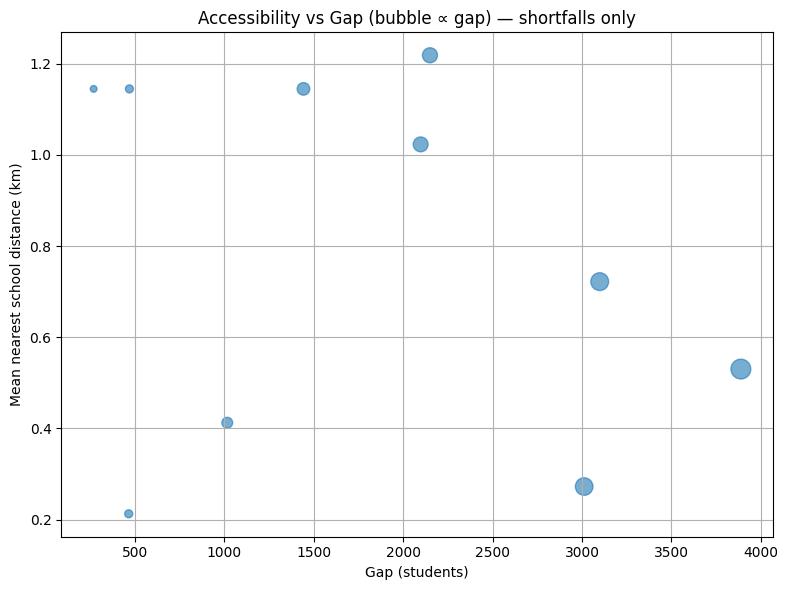

In [77]:
# Risk / Priority View (cleaned: gap × access)
if 'suburb_risk' in globals():
    risk = suburb_risk.copy()

    # Drop obvious aggregates that can distort suburb analysis
    bad_names = {"City Of Melbourne"}  # add others if needed
    risk = risk[~risk['suburb'].isin(bad_names)].copy()

    # Fill missing access with a conservative fallback (90th pct or 3km)
    if risk['mean_nearest_km'].notna().any():
        fallback = float(np.nanpercentile(risk['mean_nearest_km'], 90))
    else:
        fallback = 3.0
    risk['mean_nearest_km'] = risk['mean_nearest_km'].fillna(fallback)

    # Only consider real shortfalls; over-capacity shouldn't get priority
    risk['gap_pos'] = risk['gap_students'].clip(lower=0)

    # Risk score: bigger gaps and longer travel result in higher priority
    risk['risk_index'] = risk['gap_pos'] * (1.0 + risk['mean_nearest_km'])

    # Rank & show
    ranked = (risk.sort_values('risk_index', ascending=False)
                   [['suburb','gap_students','mean_nearest_km','risk_index']]
                   .reset_index(drop=True))

    print("Top 10 risk / priority suburbs (cleaned):")
    display(ranked.head(10))

    # Plot only true shortfalls
    plot_df = ranked[ranked['gap_students'] > 0].copy()
    plt.figure(figsize=(8,6))
    plt.scatter(plot_df['gap_students'], plot_df['mean_nearest_km'],
                s=10 + (plot_df['gap_students']*0.05), alpha=0.6)
    plt.xlabel("Gap (students)")
    plt.ylabel("Mean nearest school distance (km)")
    plt.title("Accessibility vs Gap (bubble ∝ gap) — shortfalls only")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Risk view skipped: `suburb_risk` not available.")


Melbourne, Carlton, Docklands, and Southbank are the suburbs with the highest priority for more school capacity, according to the risk study. These regions have the highest risk_index values because they have both moderate travel times to the closest schools and significant student shortages (more than 2,000–3,800 pupils). Despite having smaller gaps, suburbs including Kensington, Parkville, and North Melbourne all rank well.

This conclusion is supported by the scatter plot, which shows that demand pressure rather than just distance is the primary driver of risk because larger bubbles, or huge student gaps, show up even at less extreme distances.

##Backlog Over Time and Cumulative Unmet Demand
Monitors the annual accumulation of unmet student demand when capacity increases fall short of population growth. It is evident how little annual gaps pile up to a significant deficit if they are not addressed since the deficiency for each year is added up to create a cumulative backlog. This accumulation is illustrated in the line chart, which highlights the need for prompt interventions.

,year,shortfall,cumulative_unmet
0,2025,16091,16091
1,2026,16714,32805
2,2027,17716,50521
3,2028,19042,69563
4,2029,20359,89922
5,2030,21878,111800
6,2031,23617,135417
7,2032,25166,160583
8,2033,26952,187535
9,2034,28765,216300


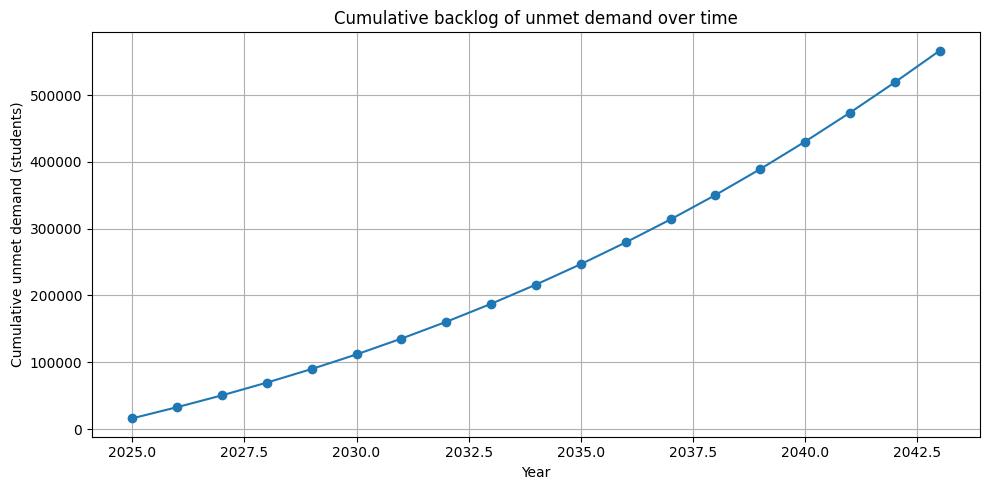

In [78]:
# Cumulative Unmet Demand
if 'scenario' in globals():
    unmet = scenario.copy()
    # Calculate shortfall
    unmet['shortfall'] = unmet['gap'].clip(lower=0)
    # Compute cumulative unmet demand by adding each year's shortfall to the previous total
    unmet['cumulative_unmet'] = unmet['shortfall'].cumsum()
    display(unmet[['year','shortfall','cumulative_unmet']].head(12))

    plt.figure(figsize=(10,5))
    plt.plot(unmet['year'], unmet['cumulative_unmet'], marker='o')
    plt.xlabel("Year"); plt.ylabel("Cumulative unmet demand (students)")
    plt.title("Cumulative backlog of unmet demand over time")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Scenario data not available for backlog plot.")


##Comparing Capacity-Addition Plans through a Stress Test
Adds seats in predetermined years and tracks the capacity and gap over time to simulate different build-out timelines (Plan A vs. Plan B). This illustrates how the timing and magnitude of investments alter the trajectory of the shortfall, assisting in the selection of a strategy that minimises gaps while mitigating delivery and budgetary risks.

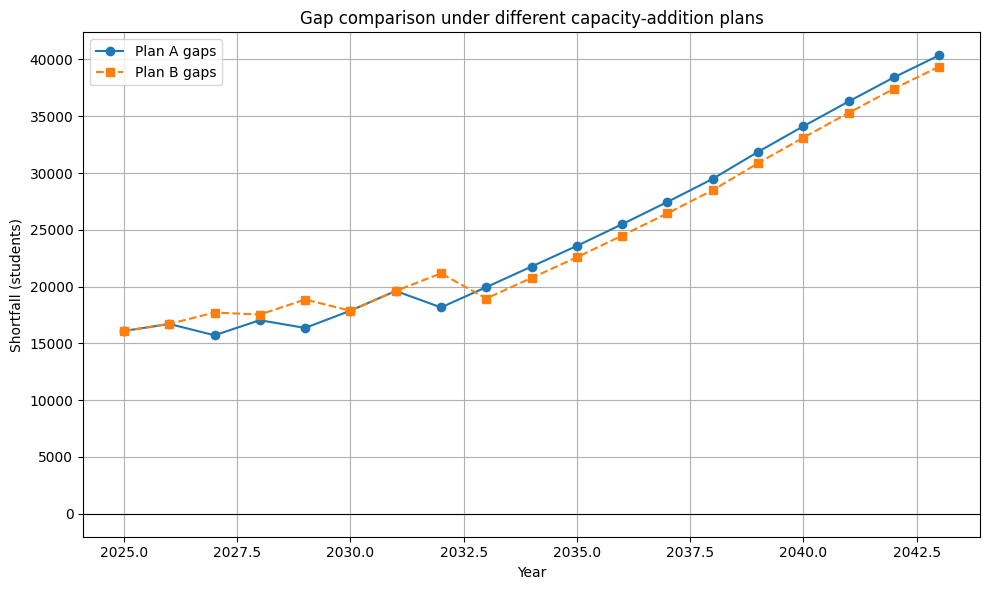

In [79]:
# Scenario Stress Test
# Define baseline total_capacity
if 'total_capacity' not in globals():
    if 'scenario' in globals() and 'capacity' in scenario.columns:
        total_capacity = float(scenario.sort_values('year')['capacity'].iloc[0])
    elif 'demand_vs_capacity' in globals() and 'capacity' in demand_vs_capacity.columns:
        total_capacity = float(demand_vs_capacity.sort_values('year')['capacity'].iloc[0])
    else:
        if 'demand_vs_capacity' in globals():
            total_capacity = float(demand_vs_capacity.sort_values('year')['school_age_pop'].iloc[0])
        else:
            raise RuntimeError("Define `total_capacity` or provide `scenario`/`demand_vs_capacity` with capacity.")

def run_capacity_plan(additions_dict, demand_frame=None):
    """Return a DataFrame with gap under a given additions plan."""
    df = (demand_frame if demand_frame is not None else demand_vs_capacity).copy()
    if 'school_age_pop' not in df.columns and 'demand_students' in df.columns:
        df = df.rename(columns={'demand_students':'school_age_pop'})
    sc = df[['year','school_age_pop']].drop_duplicates('year').sort_values('year').reset_index(drop=True)
    sc['extra'] = sc['year'].map(additions_dict).fillna(0).astype(float)
    sc['capacity'] = total_capacity + sc['extra'].cumsum()
    sc['gap'] = sc['school_age_pop'] - sc['capacity']
    return sc

# Example plans aligned to the base years
years_base = base['year'].to_numpy()
# Plan A: phased additions in years +2, +4, +7
plan_A = {int(years_base[0])+2:2000, int(years_base[0])+4:2000, int(years_base[0])+7:3000}
# Plan B: different timing and increments in years +3, +5, +8
plan_B = {int(years_base[0])+3:1500, int(years_base[0])+5:2500, int(years_base[0])+8:4000}

# Run the plans and calculate resulting gaps
scA = run_capacity_plan(plan_A, demand_frame=base)
scB = run_capacity_plan(plan_B, demand_frame=base)

plt.figure(figsize=(10,6))
plt.plot(scA['year'], scA['gap'], marker='o', label="Plan A gaps")
plt.plot(scB['year'], scB['gap'], marker='s', label="Plan B gaps", linestyle="--")
plt.axhline(0, color='k', linewidth=0.8)
plt.xlabel("Year"); plt.ylabel("Shortfall (students)")
plt.title("Gap comparison under different capacity-addition plans")
plt.legend(); plt.grid(True); plt.tight_layout(); plt.show()


## Visual Check: Less than 1% Shortfall Trajectory Development
The planning table's 1% annual growth assumption is taken out, and the shortfall trend is plotted over time. By demonstrating how demand gaps change under the assumption of moderate development, this gives policymakers a baseline case against which other scenarios or measures can be evaluated.

In [80]:
# Visual: Shortfall Trajectory (1% growth slice)
if 'planning' in globals():
    sel = planning[(planning['growth_rate']==0.01)].sort_values('year')
    plt.figure(figsize=(10,5))
    plt.plot(sel['year'], sel['shortfall'], marker='o')
    plt.xlabel("Year"); plt.ylabel("Shortfall (students)")
    plt.title("Shortfall over time under 1% growth (planning view)")
    plt.grid(True); plt.tight_layout(); plt.show()
else:
    print("Planning table not available; run sensitivity cell first.")


Planning table not available; run sensitivity cell first.


## Conclusion

This analysis shows how school capacity issues within the City of Melbourne can be assessed by combining demographic projections, enrollment information, and geographic accessibility. The study shows which communities are most at danger and where shortages are most severe by looking at distribution inequity, coverage at the suburb level, and access pressure across the city. A clear framework for prioritisation was established through the use of gap analysis, coverage testing, and a risk index. Additionally, the cumulative unmet demand model demonstrated how minor deficiencies can grow into a significant backlog if they are not addressed. Further demonstrating how the timing and scope of interventions might alter the trajectory of these gaps was the stress testing of alternate capacity-addition strategies. Finally, officials have a variety of scenarios to compare against thanks to growth-slice estimates.

All things considered, the work offers a data-driven basis for future school planning, calculating the dangers of inaction in addition to determining where and when additional capacity is required. These results can direct more timely and equitable investment choices, guaranteeing that Melbourne's educational infrastructure supports resilient, accessible education for all communities and keeps up with population growth.